In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from leela_interp.core.effect_study import *
from leela_interp.core.alternative_moves import *
from leela_interp.core.double_branch import *
from leela_interp.core.fifth_move_study import *
from leela_interp.core.checkmate_study import *
from leela_interp.core.general_study import *
from leela_interp.core.ablation_study import AblationStudy
from leela_interp.core.probing_study import ProbingStudy
from leela_interp.core.double_attention_study import *
import subprocess
# Disable FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


# 3rd move analysis

## Residual stream

In [4]:
study = CheckmateStudy(puzzlename='', load_all=True)

In [5]:
study.all_attentions.shape

torch.Size([22517, 15, 24])

PCA result shape: (22517, 5)
Explained variance ratio: [0.28669664 0.21635391 0.06003302 0.05226511 0.04630745]


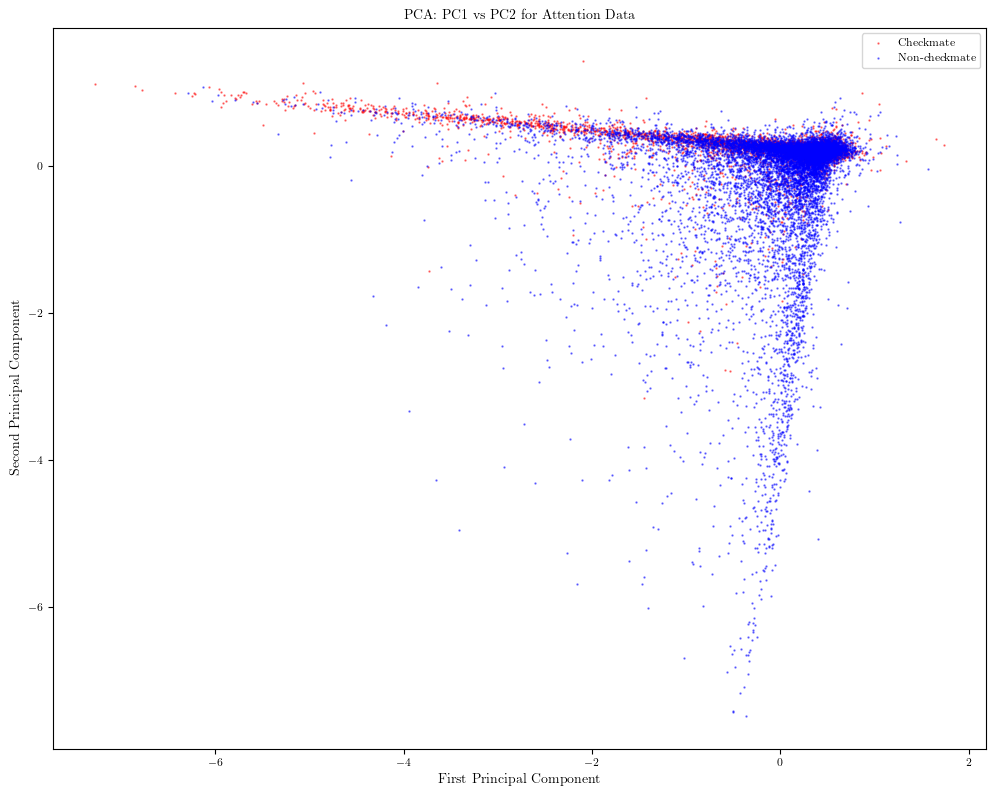

In [22]:
# Apply PCA to study.all_attentions
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reshape the tensor to 2D
attentions_2d = study.all_attentions[:, 12:, :].reshape(study.all_attentions.shape[0], -1)

# Convert to numpy array
attentions_np = attentions_2d.cpu().numpy()

# Apply PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(attentions_np)

# Print the shape of the PCA result
print("PCA result shape:", pca_result.shape)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Create a mask for checkmate puzzles
checkmate_mask = study.puzzles["Themes"].apply(lambda x: "mateIn2" in x).values

# Plot PC1 vs PC2
fig, ax = plt.subplots(figsize=(10, 8))
scatter_checkmate = ax.scatter(pca_result[checkmate_mask, 0], pca_result[checkmate_mask, 1], 
                               alpha=0.5, c='red', label='Checkmate', s=0.5)
scatter_non_checkmate = ax.scatter(pca_result[~checkmate_mask, 0], pca_result[~checkmate_mask, 1], 
                                   alpha=0.5, c='blue', label='Non-checkmate', s=0.5)

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_title('PCA: PC1 vs PC2 for Attention Data')
ax.legend()

plt.tight_layout()
plt.show()

t-SNE result shape: (1255, 2)


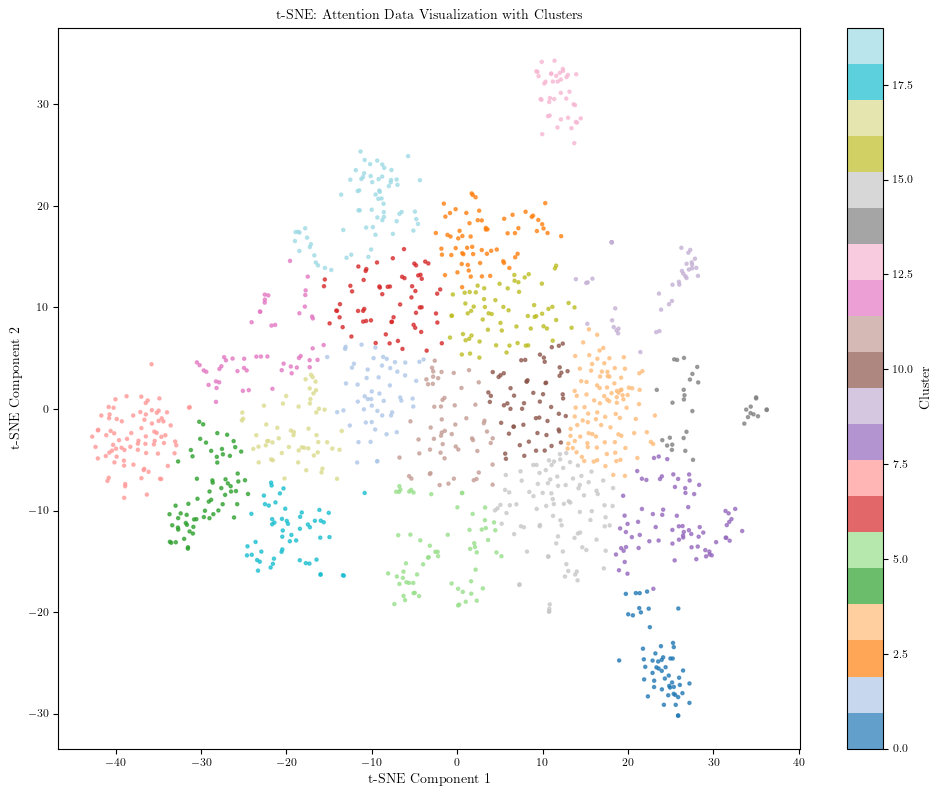

In [63]:
# Create a mask for checkmate puzzles
checkmate_mask = study.puzzles["Themes"].apply(lambda x: "mateIn3" in x)
checkmate_mask = checkmate_mask & study.puzzles.principal_variation.apply(lambda x: len(x) == 5)
checkmate_mask = checkmate_mask.values

# Reshape the tensor to 2D
attentions_2d = study.all_attentions[checkmate_mask, 10:, :].reshape(len(study.all_attentions[checkmate_mask]), -1)

# Convert to numpy array
attentions_np = attentions_2d.cpu().numpy()

# Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(attentions_np)

# Print the shape of the t-SNE result
print("t-SNE result shape:", tsne_result.shape)

# Apply KMeans clustering
from sklearn.cluster import KMeans
n_clusters = 20 # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_result)

# Plot t-SNE results with cluster colors
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=cluster_labels, cmap='tab20', 
                     alpha=0.7, s=5)

# Add colorbar to show cluster labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Add markers for checkmate puzzles
# ax.scatter(tsne_result[checkmate_mask, 0], tsne_result[checkmate_mask, 1], 
#            facecolors='none', edgecolors='red', s=20, label='Checkmate')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title(f't-SNE: Attention Data Visualization with Clusters')
#ax.legend()

plt.tight_layout()
plt.show()

# Function to get puzzles in a specific cluster
def get_puzzles_in_cluster(cluster_id):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    return study.puzzles.iloc[cluster_indices]

# Calculate the center of each cluster
# cluster_centers = kmeans.cluster_centers_

In [64]:
get_puzzles_in_cluster(13)

PuzzleId                                                FEN  \
2263     02IqG  r2r2k1/p4pn1/4pBp1/1p6/3P1Q1R/2q4P/6P1/6K1 b -...   
2665     02j28  8/3nk1r1/7q/p1pPpQ1P/PpP3P1/1P3R2/5P2/6K1 b - ...   
3389     03Qdr  r6r/1p1kbpp1/6p1/p1pp4/6P1/P2P3P/1PP2PK1/R1B1R...   
3730     03nT3  r5kr/p1pQ2b1/1p2pq2/8/3N1B2/3B4/PPP2P1P/R3K3 b...   
4661     04m4i  6k1/Q1R2r2/5n1p/3p1p1q/P2P1B2/4PnPP/1r4B1/R6K ...   
5678     05pYG  r1b2k1r/pp1p1p1p/6pb/8/N1PB4/P7/1PKn2PP/4RR2 b...   
9172     09Npd     8/2k5/2P3p1/pP1Kp1P1/P2b1p2/5P2/8/8 b - - 0 58   
13022    0DLXn  r2q1rk1/pbp2ppp/1p6/3PR3/8/P2B4/1P1Q1PPP/R5K1 ...   
13752    0E4xd  r1kq3r/8/2b2p2/1p1pn3/5B2/P7/3QBPP1/1R3RK1 w -...   
13804    0E7n6  2R5/5ppk/p7/Pp1rq1p1/1P1p4/3Q4/5PPP/6K1 b - - ...   
13844    0EAh8  8/1p2npk1/2q3p1/p2R2Pp/P1B4P/1P3Q2/5PK1/4r3 w ...   
14881    0FJCk  5r2/pp1kb1p1/1npp4/7P/3P1B2/3B4/PPP5/2K4R w - ...   
16684    0HA8i  r2k3r/pp3ppp/2pq1n2/3n4/3P4/2PB1N2/PP2QKPP/R3R...   
18348    0IrYt  r1b2rk1/2q1bppp/p1p1p3/3pP3/5P2/2BB1R2/PPP3PP/...   
20851    0LQX0  4r2k/4q2p/1Qp2pp1/2N5/3P4/5bP1/PP3P1P/2R3K1 w ...   
21140    0LiJU  2r2rk1/pb1nq3/1b3pPQ/4p3/4P3/8/4BP1P/B2R1RK1 b...   
22264    0MobZ  r7/2Qnb1kp/3p2p1/4p1P1/4P2P/5N2/1pP2P2/1q3RK1 ...   
24486    0P8Be  r4k1r/p1b3pp/1p1N1pn1/2pP4/2P2B2/1P4P1/P3R2P/2...   
24920    0PZMs  2r5/5k2/p4B1p/1b1pPn2/3P1Q2/2Pq4/6RP/2R3K1 w -...   
25714    0QMfw  b4rn1/R3p1k1/3p2p1/7p/3PP3/6PP/P1r2NB1/1R4K1 w...   
26672    0RMbl  r1b2rk1/2p1qppp/2p2n2/p1b1pP2/4P3/2P1BN2/PP1NQ...   
27562    0SL38  3r2k1/pp5p/1np1pbp1/8/4BPP1/1P5P/P1P1N3/2K4R w...   
28405    0TDEs  3R2k1/2r1bppp/pq2p3/8/P5n1/6P1/1P2PP1P/3Q1RK1 ...   
31070    0VvA3  r5k1/pbp3pp/2p4n/8/4B3/2P1P2P/PP1N4/2K2R2 b - ...   
33852    0Ym9b  5rk1/ppr2ppp/n2Np3/8/3R4/PP2P1Q1/2q2PPP/R5K1 w...   
35661    0abWA  3r2k1/3qRp1p/5Qp1/8/3p4/6P1/1P3P1P/6K1 b - - 2 32   
36893    0by0U  2b2q1k/8/1pp4p/4N3/1P3n2/2P4P/P2Q1PP1/6K1 b - ...   
38034    0dAmE  5rk1/3n1bpp/1q3p2/pB1PpN2/1n2P3/2r2P2/1P3QPP/2...   
38289    0dQDv  r1b1R3/1p6/p2k4/2bB3p/2P4P/3P2P1/PP3P2/6K1 w -...   
38559    0dimr           8/4Q3/1P6/4k3/8/3K4/2P5/4r1q1 b - - 4 62   
39752    0eyjD      3r4/R5p1/5pk1/1P5P/2B1PK2/3P4/8/7r b - - 0 46   
40480    0flVf    8/2Q1kp2/p2pq1p1/2p5/7r/8/PPP5/1K3R2 b - - 5 36   
40541    0foww  1n1r4/1p3pp1/r5kp/q4b2/3Q1P1b/2N5/PPP4P/2KR2R1...   
42779    0i8Bx  1R3k1r/3pppb1/5np1/2P5/3P3p/2N1PQP1/3q1P1P/6K1...   
43567    0ivcP  r1b2rk1/1p1pQ1p1/4pp1p/p7/P1N1q3/6R1/5PPP/5RK1...   
44378    0jiUb  r1bqkb1r/ppp2ppp/5n2/3np1B1/8/1B6/PP3PPP/RN1QK...   
44645    0k1T8  rnbqkb1r/p3pppp/5n2/1N1P4/2p5/8/PP3PPP/R1BQKBN...   
48572    0nzex  8/N1prk1p1/5p2/8/7Q/2P1p1p1/PP1P1q1N/R1BK3R w ...   
49473    0oyZC  4nbk1/R4p1p/p7/6p1/4P1P1/PPr2K2/7P/4R3 w - - 3 31   
49766    0pGnW  5rk1/1Q3pp1/4p2p/p3P3/2q5/5R2/P5PP/5R1K w - - ...   

                                                   Moves  Rating  \
2263                       d8d5 h4h8 g8h8 f4h6 h8g8 h6g7    1779   
2665                                 h6f6 f5d7 e7d7 f3f6    1658   
3389                       h8h4 e1e7 d7e7 c1g5 e7d7 g5h4    1144   
3730                       f6f4 d7g7 g8g7 d4e6 g7f6 e6f4    2241   
4661                                 c7f7 h5h3 g2h3 b2h2    1770   
5678                       h6g7 d4c5 d7d6 c5d6 f8g8 e1e8    2160   
9172   d4a1 b5b6 c7b6 d5d6 e5e4 c6c7 a1e5 d6e5 b6c7 e5e4    2199   
13022                      b7d5 e5d5 d8d5 d3h7 g8h7 d2d5    1619   
13752                      e2b5 e5f3 g2f3 d8g8 f4g5 g8h7    2204   
13804                                g7g6 d3h3 h7g7 h3h8     947   
13844                                d5b5 e1g1 g2g1 c6f3    1091   
14881                      h1f1 f8f4 f1f4 e7g5 c1b1 g5f4    2061   
16684                                e2e5 f6g4 f2g1 g4e5    1129   
18348                                c6c5 d3h7 g8h7 f3h3    1714   
20851                      h2h4 e7e1 c1e1 e8e1 g1h2 e1h1     590   
21140                      e7g7 h6g7 g8g7 d1d7 g7g6 d7b7    1707   
22264               

t-SNE result shape: (22517, 2)


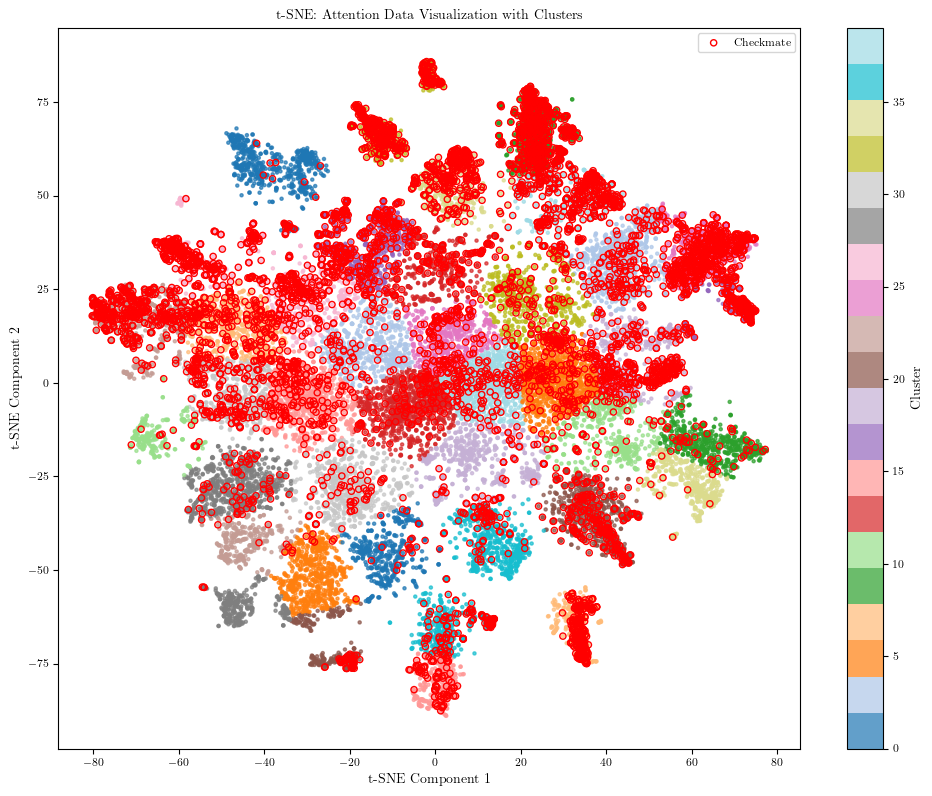

In [26]:
# Reshape the tensor to 2D
N = 22517
attentions_2d = study.all_attentions[:N, :, :].reshape(N, -1)

# Convert to numpy array
attentions_np = attentions_2d.cpu().numpy()

# Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(attentions_np)

# Print the shape of the t-SNE result
print("t-SNE result shape:", tsne_result.shape)

# Create a mask for checkmate puzzles
checkmate_mask = study.puzzles.iloc[:N]["Themes"].apply(lambda x: "mateIn2" in x).values

# Apply KMeans clustering
from sklearn.cluster import KMeans
n_clusters = 40 # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_result)

# Plot t-SNE results with cluster colors
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=cluster_labels, cmap='tab20', 
                     alpha=0.7, s=5)

# Add colorbar to show cluster labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Add markers for checkmate puzzles
ax.scatter(tsne_result[checkmate_mask, 0], tsne_result[checkmate_mask, 1], 
           facecolors='none', edgecolors='red', s=20, label='Checkmate')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title(f't-SNE: Attention Data Visualization with Clusters')
ax.legend()

plt.tight_layout()
plt.show()

# Function to get puzzles in a specific cluster
def get_puzzles_in_cluster(cluster_id):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    return study.puzzles.iloc[cluster_indices]

# Calculate the center of each cluster
# cluster_centers = kmeans.cluster_centers_

In [33]:
checkmate_mask = study.puzzles.iloc[:N]["Themes"].apply(lambda x: "mateIn5" in x).values
#checkmate_mask = checkmate_mask & study.puzzles.iloc[:N].principal_variation.apply(lambda x: len(x) == 7)

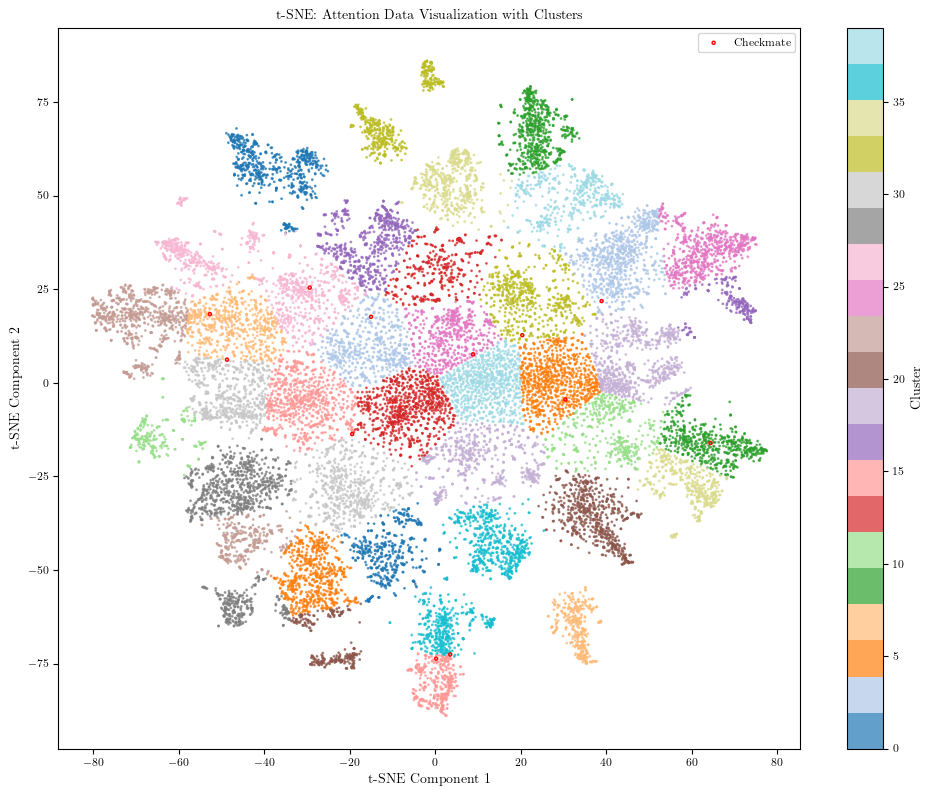

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=cluster_labels, cmap='tab20', 
                     alpha=0.7, s=1)

# Add colorbar to show cluster labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Add markers for checkmate puzzles
ax.scatter(tsne_result[checkmate_mask, 0], tsne_result[checkmate_mask, 1], 
           facecolors='none', edgecolors='red', s=5, label='Checkmate')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title(f't-SNE: Attention Data Visualization with Clusters')
ax.legend()

plt.tight_layout()
plt.show()

In [31]:
cluster_centers = kmeans.cluster_centers_

In [36]:
cluster_centers[26:28]

array([[-29.72949 ,  23.35608 ],
       [-55.38313 ,  34.798046]], dtype=float32)

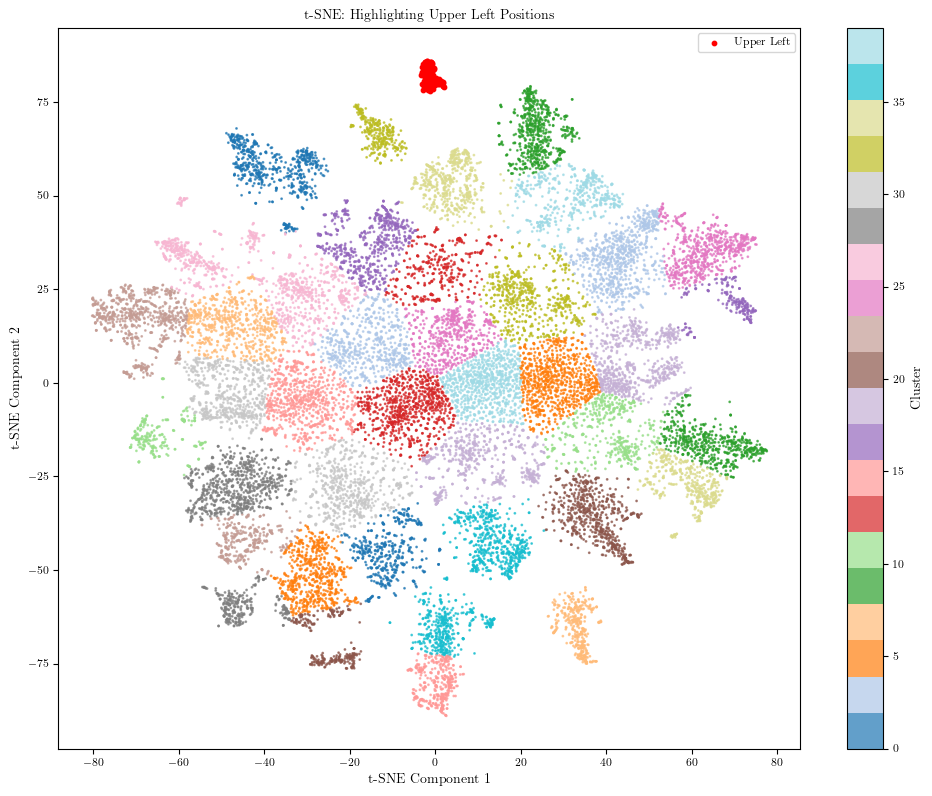

Number of positions in the upper left: 140

Sample of positions in the upper left:
Index: 215, PuzzleId: 09SS5, FEN: r5k1/4Qpp1/6P1/3p4/2q5/p3R3/5P2/6K1 b - - 0 32
Index: 480, PuzzleId: 0K3hv, FEN: r4rk1/pp5p/3q4/3P4/2R3pP/P1Q2pK1/1P3N2/5R2 w - - 1 33
Index: 748, PuzzleId: 0VEYH, FEN: 3r4/p2rk3/1p2p2p/5p2/2PPKP1P/1P6/3R4/3R4 w - - 0 34
Index: 1160, PuzzleId: 0mv4f, FEN: 6k1/1r4p1/5b1p/3p1B1P/p1r2P2/P1P5/1PK5/3RR3 b - - 2 32
Index: 1232, PuzzleId: 0rH7J, FEN: 8/5p2/5Rp1/Pp5p/3K1k2/1r5P/6P1/8 b - - 1 40


In [50]:
upper_left_mask = (tsne_result[:, 0] < 10) & (tsne_result[:, 1] > 75)

# Plot the t-SNE results again, highlighting the upper left positions
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all points
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=cluster_labels, cmap='tab20', 
                     alpha=0.7, s=1)

# Highlight upper left positions
ax.scatter(tsne_result[upper_left_mask, 0], tsne_result[upper_left_mask, 1], 
           color='red', s=10, label='Upper Left')

# Add colorbar to show cluster labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('t-SNE: Highlighting Upper Left Positions')
ax.legend()

plt.tight_layout()
plt.show()

# Print the number of positions in the upper left
print(f"Number of positions in the upper left: {np.sum(upper_left_mask)}")

# Get the indices of the upper left positions
upper_left_indices = np.where(upper_left_mask)[0]

# Print some information about these positions
print("\nSample of positions in the upper left:")
for idx in upper_left_indices[:5]:  # Print first 5 as a sample
    puzzle = study.puzzles.iloc[idx]
    print(f"Index: {idx}, PuzzleId: {puzzle['PuzzleId']}, FEN: {puzzle['FEN']}")


In [53]:
example_puzzles = study.puzzles.iloc[upper_left_indices]

# Only keep FEN, Rating, Themes, principal_variation columns
example_puzzles = example_puzzles[['FEN', 'Rating', 'Themes', 'principal_variation']]

# Display all example puzzles
print(example_puzzles)

# Get the number of example puzzles
num_puzzles = len(example_puzzles)
print(f"\nTotal number of example puzzles: {num_puzzles}")

# Display some statistics about the ratings
print("\nRating statistics:")
print(example_puzzles['Rating'].describe())

# Count the occurrences of each theme
theme_counts = example_puzzles['Themes'].str.split().explode().value_counts()
print("\nTop 10 most common themes:")
print(theme_counts.head(10))

# Display a few example boards
print("\nDisplaying 3 example boards:")
for i in range(min(3, num_puzzles)):
    puzzle = example_puzzles.iloc[i]
    print(f"\nPuzzle {i+1}:")
    print(f"FEN: {puzzle['FEN']}")
    print(f"Rating: {puzzle['Rating']}")
    print(f"Themes: {puzzle['Themes']}")
    print(f"Principal Variation: {puzzle['principal_variation']}")
    print(LeelaBoard.from_fen(puzzle['FEN']))


                                                      FEN  Rating  \
9265       r5k1/4Qpp1/6P1/3p4/2q5/p3R3/5P2/6K1 b - - 0 32    1466   
19507   r4rk1/pp5p/3q4/3P4/2R3pP/P1Q2pK1/1P3N2/5R2 w -...    1398   
30390   3r4/p2rk3/1p2p2p/5p2/2PPKP1P/1P6/3R4/3R4 w - -...    1613   
47506   6k1/1r4p1/5b1p/3p1B1P/p1r2P2/P1P5/1PK5/3RR3 b ...    1422   
51819         8/5p2/5Rp1/Pp5p/3K1k2/1r5P/6P1/8 b - - 1 40    1674   
...                                                   ...     ...   
983352     8/1p1k4/2p3p1/1pK3P1/1P1P4/P1P5/8/8 w - - 2 43    1794   
989025  2b2r2/5p1k/3QpPpp/1pp2q2/8/3R4/rP3PPP/5RK1 b -...    1059   
992560  r1b2r1k/1pB3bP/p4p2/3Q4/2n1n1q1/1B3N2/PPP3PP/R...    1456   
995461  1k1r4/p3b3/Pp1q3p/4p1p1/4P1n1/4B1PB/2Q2P1P/2R3...     917   
999356  5rk1/pp6/3p2q1/2p1p3/1PP1Pp2/P1R2P1p/6rP/3QBR1...    1312   

                                                   Themes  \
9265                 endgame mate mateIn2 sacrifice short   
19507                       mate mateIn2 middlega

In [55]:
import pandas as pd

In [56]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Display all rows and columns from example_puzzles
print(example_puzzles.to_string())

# Reset display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


                                                                        FEN  Rating                                                                               Themes                                     principal_variation
9265                         r5k1/4Qpp1/6P1/3p4/2q5/p3R3/5P2/6K1 b - - 0 32    1466                                                 endgame mate mateIn2 sacrifice short                                      [e7e8, a8e8, e3e8]
19507                 r4rk1/pp5p/3q4/3P4/2R3pP/P1Q2pK1/1P3N2/5R2 w - - 1 33    1398                                                        mate mateIn2 middlegame short                                      [d6g6, g4h3, g6g2]
30390                   3r4/p2rk3/1p2p2p/5p2/2PPKP1P/1P6/3R4/3R4 w - - 0 34    1613                                     endgame mate mateIn2 rookEndgame sacrifice short                                      [d7d5, c4d5, d8d5]
47506                6k1/1r4p1/5b1p/3p1B1P/p1r2P2/P1P5/1PK5/3RR3 b - - 2 32    1422                 

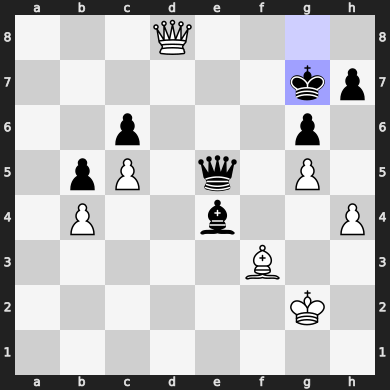

In [49]:
LeelaBoard.from_puzzle(study.puzzles.iloc[upper_left_indices].iloc[0])

In [37]:
get_puzzles_in_cluster(27)

PuzzleId                                                FEN  \
8981      09BED  6k1/5pp1/pq5p/4p3/P1r1B3/5Q2/5PPP/3R2K1 w - - ...   
10107     0ALUW  r3k2r/pp1nqpp1/2p1p3/8/1b1PQB1P/8/PPP5/2KR1B1R...   
10269     0AVRV     4rr2/6pk/1R6/p1PQ4/P5p1/8/5qPP/1R5K w - - 4 36   
14488     0EsSZ  2k5/ppp1np1r/2p2B1p/2b5/4P3/2N2P1q/PPP1KP2/3R2...   
16238     0GiIY  rnkr4/pp2bppp/2p1p3/8/R2P1B2/1P1B1P2/1P3PPP/2R...   
...         ...                                                ...   
982446    GB29o  5rrk/R1R3p1/1p2p2p/4Np1Q/5q2/P6P/6P1/7K b - - ...   
982516    GB6pK   5rk1/5ppp/R1N1p3/1P6/2P3K1/Q4nP1/7q/8 b - - 1 43   
990971    GJkO5  r6k/1p3r2/p2q3b/7N/6pP/2P5/PPQ1R3/1K2R3 w - - ...   
996247    GP6s5  1k5r/p1p2ppp/Bb3n2/3r4/5B2/1R6/PP4PP/2R4K b - ...   
997456    GQKxi       3R4/2p2Bpk/8/4bPp1/6P1/p6P/1r6/7K b - - 0 37   

                                Moves  Rating  RatingDeviation  Popularity  \
8981    d1b1 b6b1 e4b1 c4c1 f3d1 c1d1     728               77         100   
10107             e8c8 e4c6 b7c6 f1a6    1654               79          91   
10269             b1g1 f2g1 h1g1 e8e1    1764               78          84   
14488             h3h2 g1g8 e7g8 d1d8    1401               82          88   
16238             b8d7 c1c6 b7c6 d3a6    1091               98          72   
...                               ...     ...              ...         ...   
982446            f4e5 h5h6 g7h6 c7h7    1478               75          82   
982516            f3g1 a3f8 g8f8 a6a8    1655               74          95   
990971  e2e6 d6e6 e1e6 f7f1 c2d1 f1d1    1423               74          93   
996247            h8d8 f4c7 b8a8 c7d8    1551               74          92   
997456            a3a2 f7g6 h7h6 d8h8    1243               75          97   

        NbPlays                                             Themes  \
8981        256  backRankMate endgame fork long mate mateIn3 sa...   
10107      1814  bodenMate mate mateIn2 middlegame queensideAtt...   
10269       158    attraction endgame mate mateIn2 sacrifice short   
14488        54            mate mateIn2 middlegame sacrifice short   
16238      3154  bodenMate mate mateIn2 middlegame queensideAtt...   
...         ...                                                ...   
982446      133               endgame mate mateIn2 sacrifice short   
982516    10297    attraction endgame mate mateIn2 sacrifice short   
990971     3242                 crushing long middlegame sacrifice   
996247     2031                     crushing fork middlegame short   
997456    15824                         endgame mate mateIn2 short   

                                      GameUrl  \
8981          https://lichess.org/HBItIvT7#52   
10107   https://lichess.org/qlIC64I0/black#35   
10269         https://lichess.org/uesdO3xC#70   
14488   https://lichess.org/hQtd9Arj/black#31   
16238   https://lichess.org/DjMM2PDH/black#29   
...                                       ...   
982446  https://lichess.org/FyudUlL1/black#81   
982516  https://lichess.org/biHTEuDQ/black#85   
990971        https://lichess.org/Y3q78gJz#62   
996247  https://lichess.org/iuA8ASPy/black#45   
997456  https://lichess.org/EwNpbAxa/black#73   

                                              OpeningTags  \
8981                                                  NaN   
10107   Rapport-Jobava_System Rapport-Jobava_System_Ot...   
10269                                                 NaN   
14488                Ruy_Lopez Ruy_Lopez_Other_variations   
16238   Slav_Defense Slav_Defense_Three_Knights_Variation   
...                                                   ...   
982446                                                NaN   
982516                                                NaN   
990971                                                NaN   
996247                                                NaN   
997456                                                NaN   

                   principal_variation  \
8981    [b6b1, e4b1, c4c

In [45]:
boards = [LeelaBoard.from_puzzle(puzzle) for _, puzzle in study.puzzles.iloc[:1000].iterrows()]
with model.trace(boards):
    act_array = [model.residual_stream(layer).output.save() for layer in range(15)]

In [46]:
act_values = [act.value for act in act_array]

PCA result shape: (1000, 5)
Explained variance ratio: [0.05429494 0.03019626 0.02629316 0.02036205 0.01877136]


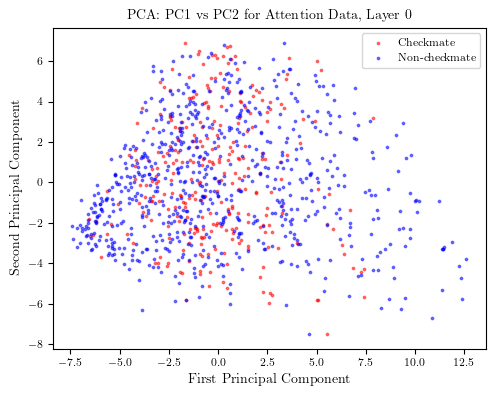

PCA result shape: (1000, 5)
Explained variance ratio: [0.04165022 0.02647007 0.01941395 0.01688363 0.01497317]


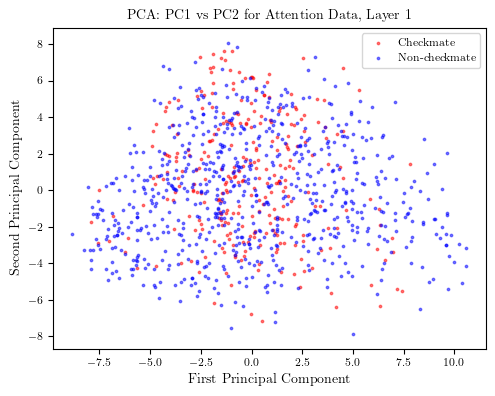

PCA result shape: (1000, 5)
Explained variance ratio: [0.04020381 0.02513801 0.01969989 0.01621012 0.01507769]


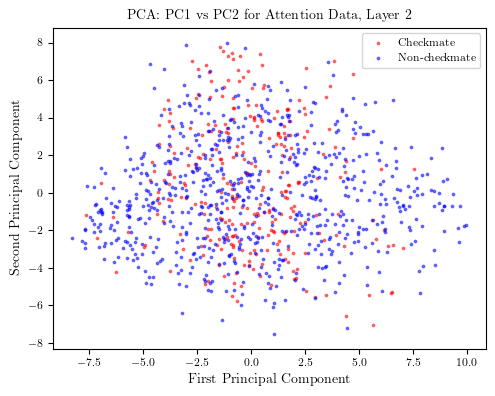

PCA result shape: (1000, 5)
Explained variance ratio: [0.0335476  0.02518461 0.02262731 0.0166824  0.01360211]


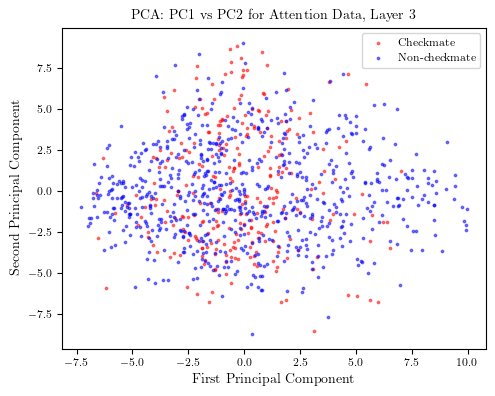

PCA result shape: (1000, 5)
Explained variance ratio: [0.03776405 0.02540713 0.01832975 0.01426858 0.0133927 ]


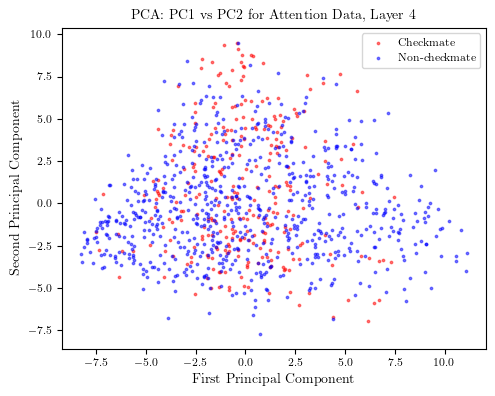

PCA result shape: (1000, 5)
Explained variance ratio: [0.03242541 0.02257655 0.01832394 0.01419604 0.01175436]


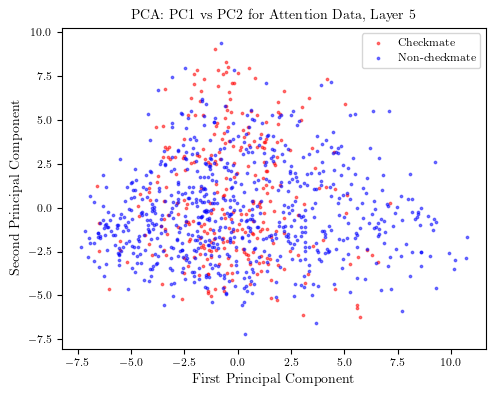

PCA result shape: (1000, 5)
Explained variance ratio: [0.0301695  0.02342088 0.01807912 0.01352193 0.01186823]


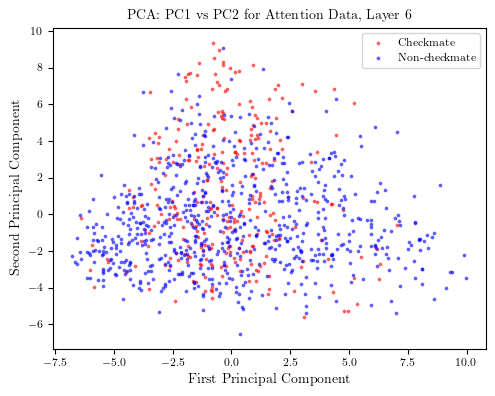

PCA result shape: (1000, 5)
Explained variance ratio: [0.02816287 0.02159531 0.01706668 0.01276071 0.01096538]


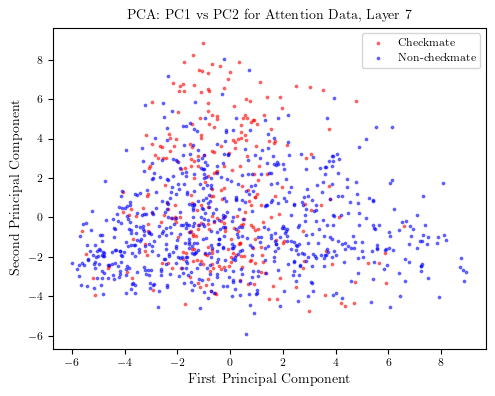

PCA result shape: (1000, 5)
Explained variance ratio: [0.02683172 0.02144994 0.01762117 0.01325464 0.01120855]


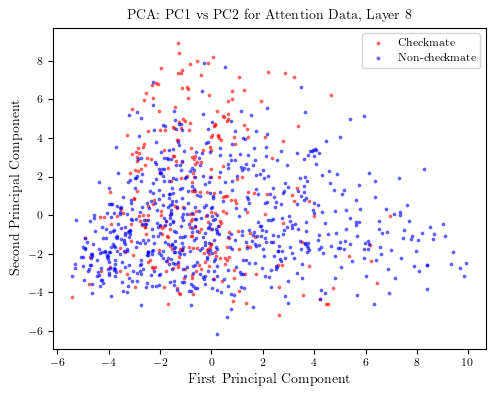

PCA result shape: (1000, 5)
Explained variance ratio: [0.02529213 0.02174447 0.01691339 0.01270886 0.01030125]


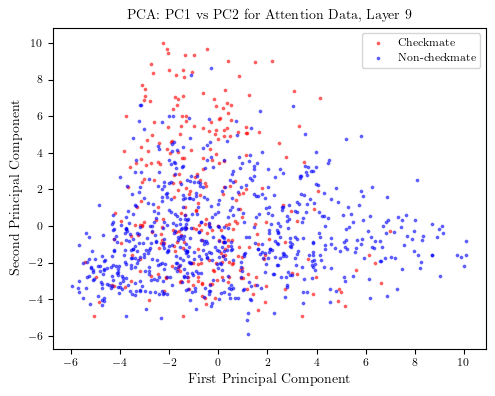

PCA result shape: (1000, 5)
Explained variance ratio: [0.02113833 0.01917147 0.01536334 0.01126625 0.00943052]


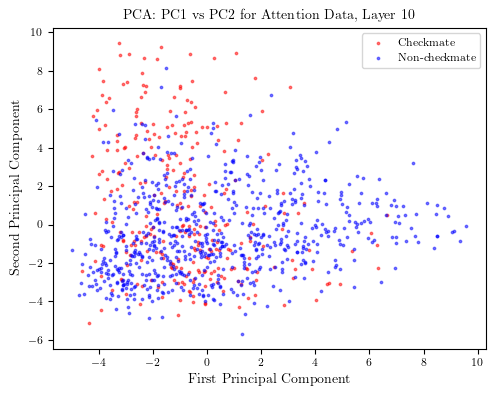

PCA result shape: (1000, 5)
Explained variance ratio: [0.01983136 0.01883118 0.01535827 0.01129732 0.0094288 ]


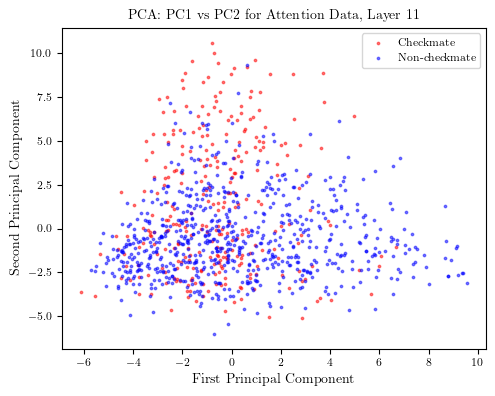

PCA result shape: (1000, 5)
Explained variance ratio: [0.02040681 0.01895438 0.01636796 0.01133468 0.01112434]


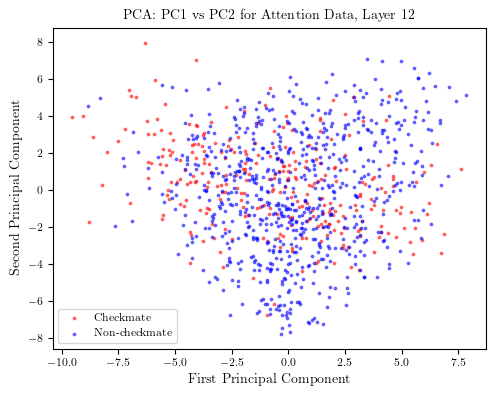

PCA result shape: (1000, 5)
Explained variance ratio: [0.02840465 0.02355767 0.01947324 0.01448003 0.01211625]


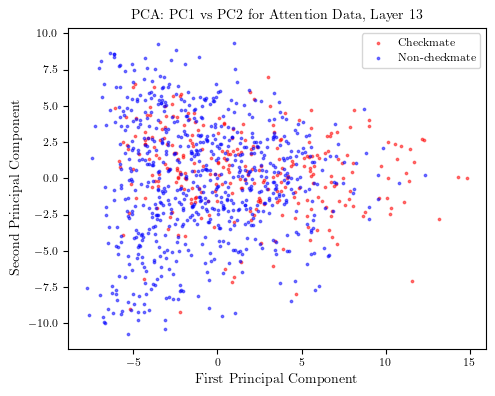

PCA result shape: (1000, 5)
Explained variance ratio: [0.17309986 0.06032384 0.04044897 0.03331783 0.01930422]


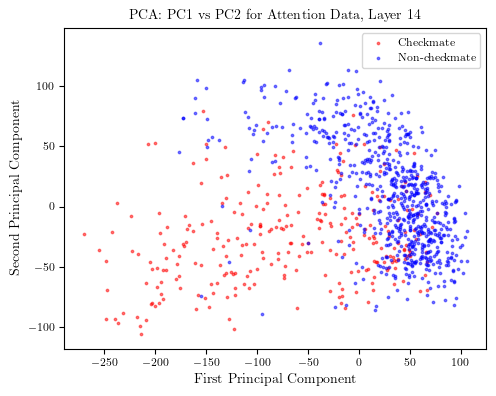

In [51]:
# Apply PCA to study.all_attentions
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

for i in range(15):

    # Reshape the tensor to 2D
    attentions_2d = act_values[i].reshape(len(boards), -1)

    # Convert to numpy array
    attentions_np = attentions_2d.cpu().numpy()

    # Apply PCA
    pca = PCA(n_components=5)
    pca_result = pca.fit_transform(attentions_np)

    # Print the shape of the PCA result
    print("PCA result shape:", pca_result.shape)

    # Print the explained variance ratio
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    # Create a mask for checkmate puzzles
    checkmate_mask = study.puzzles.iloc[:len(boards)]["Themes"].apply(lambda x: "mateIn2" in x).values
    #checkmate_mask_1 = study.puzzles.iloc[:len(boards)].principal_variation.apply(lambda x: len(x) == 3).values
    #checkmate_mask_2 = study.puzzles.iloc[:len(boards)].principal_variation.apply(lambda x: x[0][2:4] == x[1][2:4] == x[2][2:4]).values
    #checkmate_mask = checkmate_mask_1 & checkmate_mask_2

    # Plot PC1 vs PC2
    fig, ax = plt.subplots(figsize=(5, 4))
    scatter_checkmate = ax.scatter(pca_result[checkmate_mask, 0], pca_result[checkmate_mask, 1], 
                                alpha=0.5, c='red', label='Checkmate', s=3)
    scatter_non_checkmate = ax.scatter(pca_result[~checkmate_mask, 0], pca_result[~checkmate_mask, 1], 
                                    alpha=0.5, c='blue', label='Non-checkmate', s=3)

    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title(f'PCA: PC1 vs PC2 for Attention Data, Layer {i}')
    ax.legend()

    plt.tight_layout()
    plt.show()

t-SNE result shape: (1000, 2)


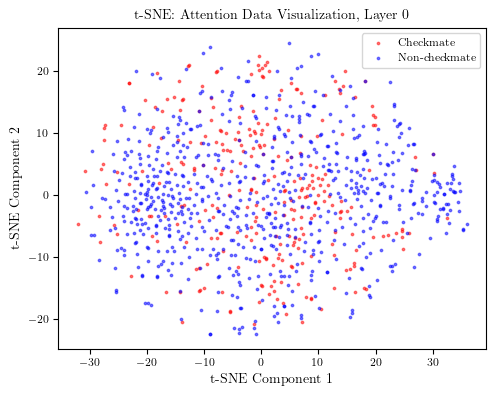

t-SNE result shape: (1000, 2)


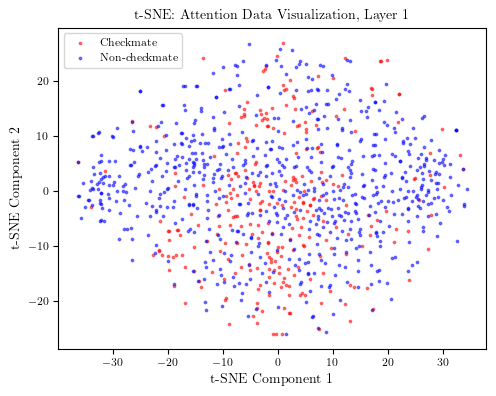

t-SNE result shape: (1000, 2)


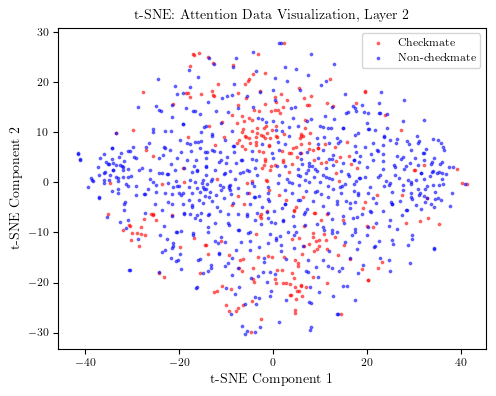

t-SNE result shape: (1000, 2)


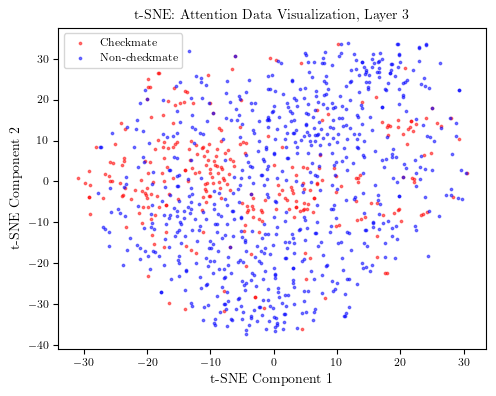

t-SNE result shape: (1000, 2)


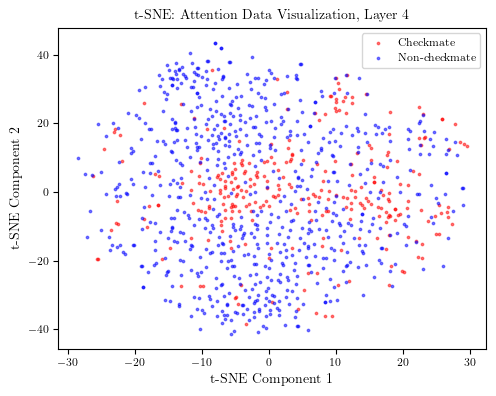

t-SNE result shape: (1000, 2)


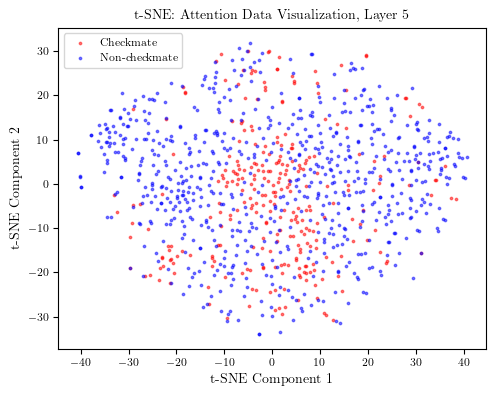

t-SNE result shape: (1000, 2)


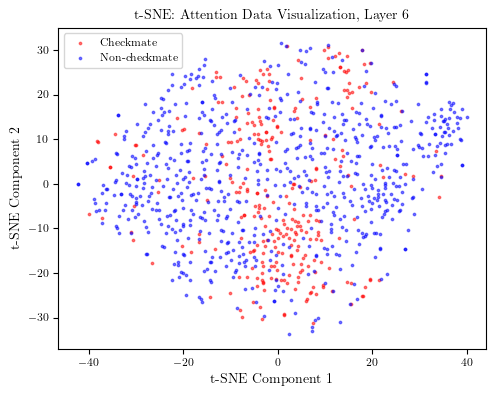

t-SNE result shape: (1000, 2)


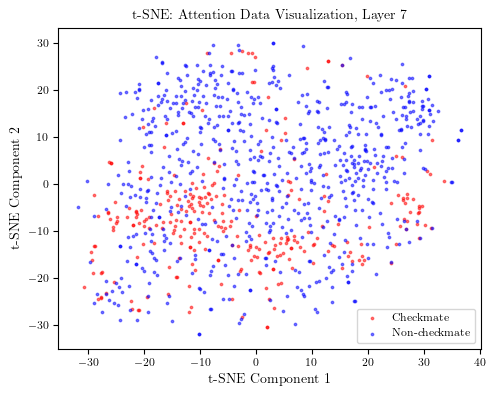

t-SNE result shape: (1000, 2)


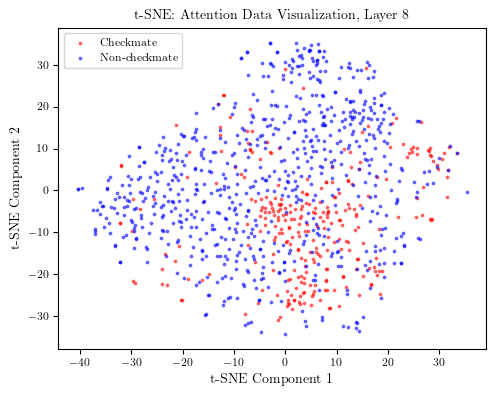

t-SNE result shape: (1000, 2)


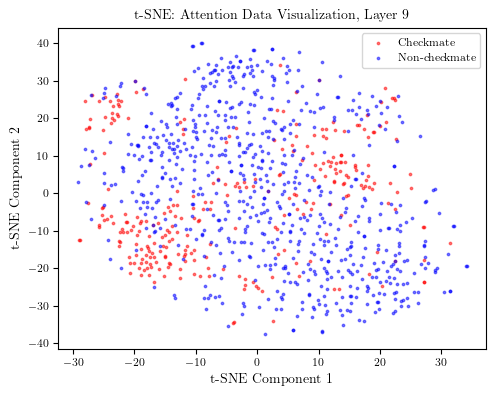

t-SNE result shape: (1000, 2)


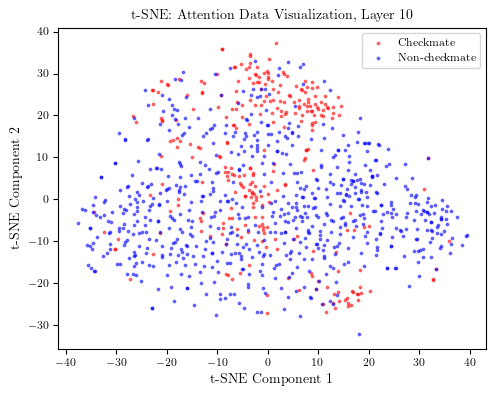

t-SNE result shape: (1000, 2)


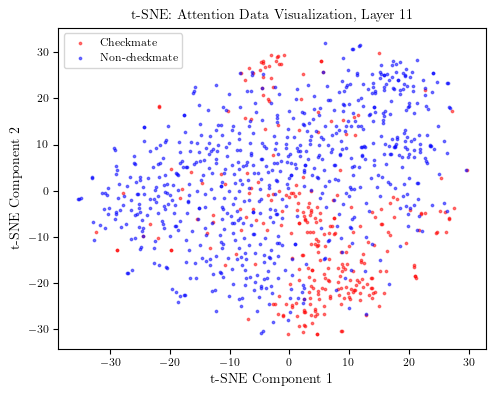

t-SNE result shape: (1000, 2)


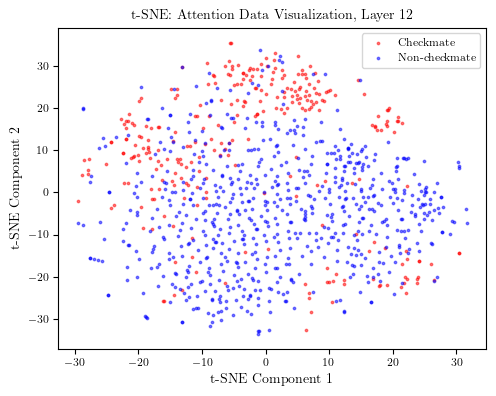

t-SNE result shape: (1000, 2)


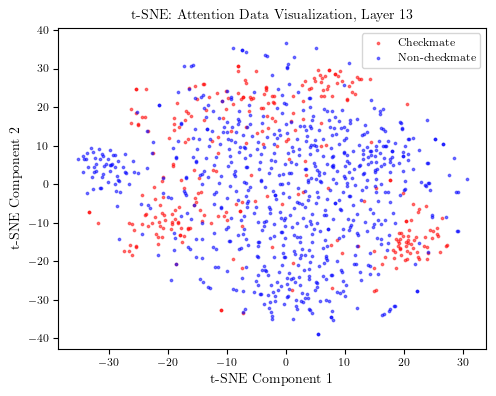

t-SNE result shape: (1000, 2)


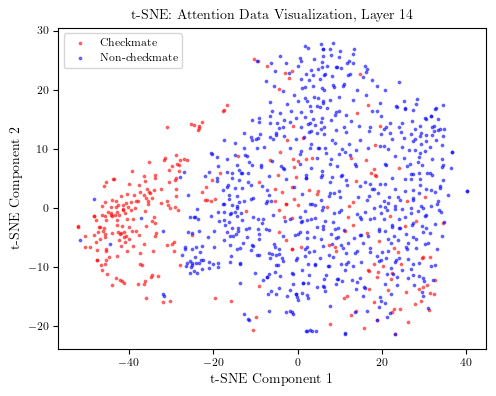

'\n# Apply UMAP to study.all_attentions\nfrom umap import UMAP\n\nfor i in range(15):\n\n    # Reshape the tensor to 2D\n    attentions_2d = act_values[i].reshape(len(boards), -1)\n\n    # Convert to numpy array\n    attentions_np = attentions_2d.cpu().numpy()\n\n    # Apply UMAP\n    umap = UMAP(n_components=2, random_state=42)\n    umap_result = umap.fit_transform(attentions_np)\n\n    # Print the shape of the UMAP result\n    print("UMAP result shape:", umap_result.shape)\n\n    # Create a mask for checkmate puzzles\n    checkmate_mask = study.puzzles.iloc[:len(boards)]["Themes"].apply(lambda x: "mateIn2" in x).values\n\n    # Plot UMAP results\n    fig, ax = plt.subplots(figsize=(5, 4))\n    scatter_checkmate = ax.scatter(umap_result[checkmate_mask, 0], umap_result[checkmate_mask, 1], \n                                alpha=0.5, c=\'red\', label=\'Checkmate\', s=3)\n    scatter_non_checkmate = ax.scatter(umap_result[~checkmate_mask, 0], umap_result[~checkmate_mask, 1], \n          

In [52]:
# Apply t-SNE to study.all_attentions
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

for i in range(15):

    # Reshape the tensor to 2D
    attentions_2d = act_values[i].reshape(len(boards), -1)

    # Convert to numpy array
    attentions_np = attentions_2d.cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(attentions_np)

    # Print the shape of the t-SNE result
    print("t-SNE result shape:", tsne_result.shape)

    # Create a mask for checkmate puzzles
    checkmate_mask = study.puzzles.iloc[:len(boards)]["Themes"].apply(lambda x: "mateIn2" in x).values

    # Plot t-SNE results
    fig, ax = plt.subplots(figsize=(5, 4))
    scatter_checkmate = ax.scatter(tsne_result[checkmate_mask, 0], tsne_result[checkmate_mask, 1], 
                                alpha=0.5, c='red', label='Checkmate', s=3)
    scatter_non_checkmate = ax.scatter(tsne_result[~checkmate_mask, 0], tsne_result[~checkmate_mask, 1], 
                                    alpha=0.5, c='blue', label='Non-checkmate', s=3)

    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title(f't-SNE: Attention Data Visualization, Layer {i}')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Uncomment the following block to use UMAP instead of t-SNE
'''
# Apply UMAP to study.all_attentions
from umap import UMAP

for i in range(15):

    # Reshape the tensor to 2D
    attentions_2d = act_values[i].reshape(len(boards), -1)

    # Convert to numpy array
    attentions_np = attentions_2d.cpu().numpy()

    # Apply UMAP
    umap = UMAP(n_components=2, random_state=42)
    umap_result = umap.fit_transform(attentions_np)

    # Print the shape of the UMAP result
    print("UMAP result shape:", umap_result.shape)

    # Create a mask for checkmate puzzles
    checkmate_mask = study.puzzles.iloc[:len(boards)]["Themes"].apply(lambda x: "mateIn2" in x).values

    # Plot UMAP results
    fig, ax = plt.subplots(figsize=(5, 4))
    scatter_checkmate = ax.scatter(umap_result[checkmate_mask, 0], umap_result[checkmate_mask, 1], 
                                alpha=0.5, c='red', label='Checkmate', s=3)
    scatter_non_checkmate = ax.scatter(umap_result[~checkmate_mask, 0], umap_result[~checkmate_mask, 1], 
                                    alpha=0.5, c='blue', label='Non-checkmate', s=3)

    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.set_title(f'UMAP: Attention Data Visualization, Layer {i}')
    ax.legend()

    plt.tight_layout()
    plt.show()
'''

UMAP result shape: (1000, 2)


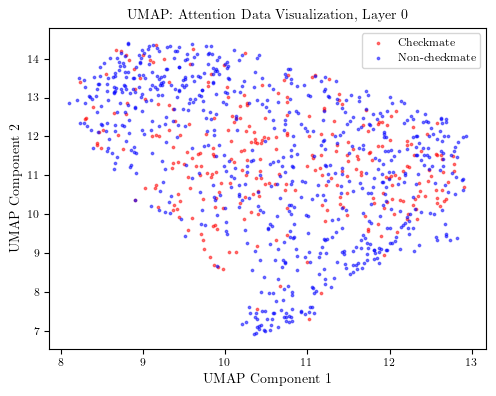

UMAP result shape: (1000, 2)


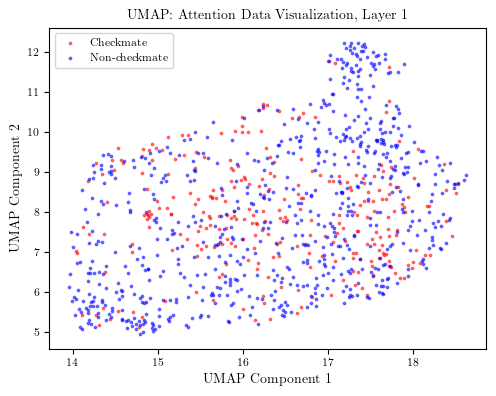

UMAP result shape: (1000, 2)


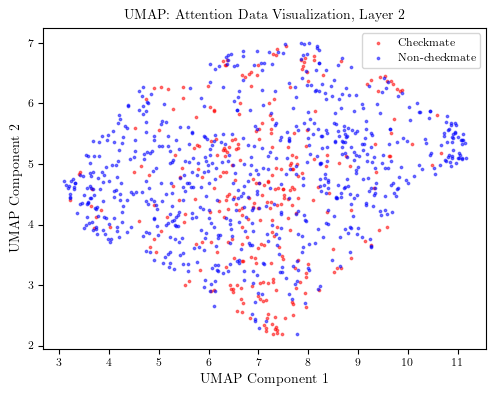

UMAP result shape: (1000, 2)


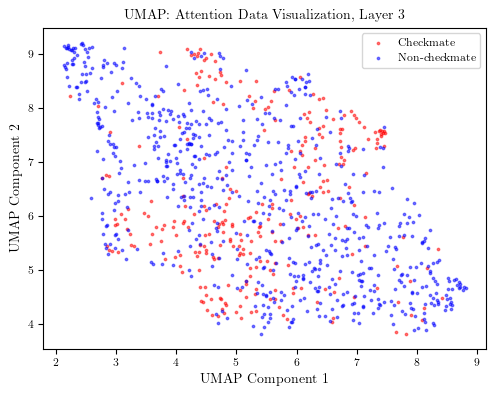

UMAP result shape: (1000, 2)


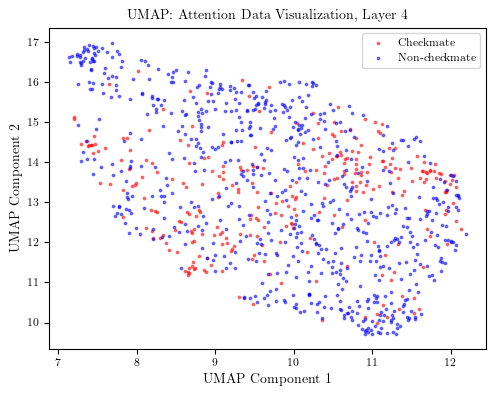

UMAP result shape: (1000, 2)


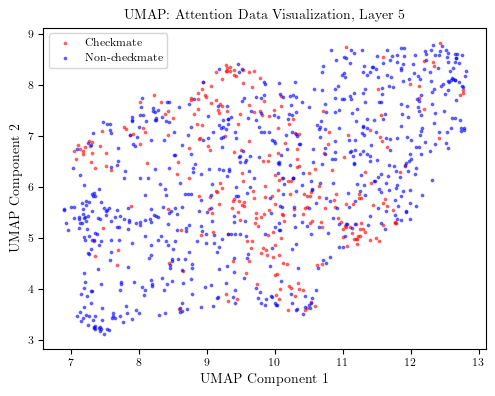

UMAP result shape: (1000, 2)


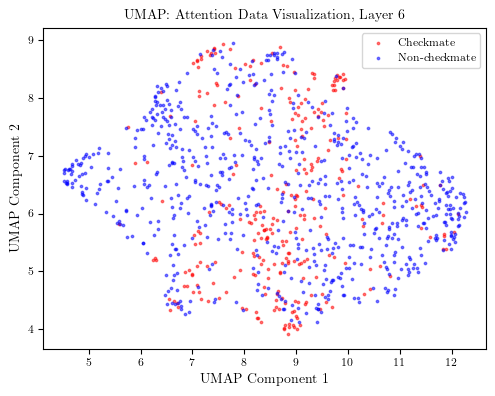

UMAP result shape: (1000, 2)


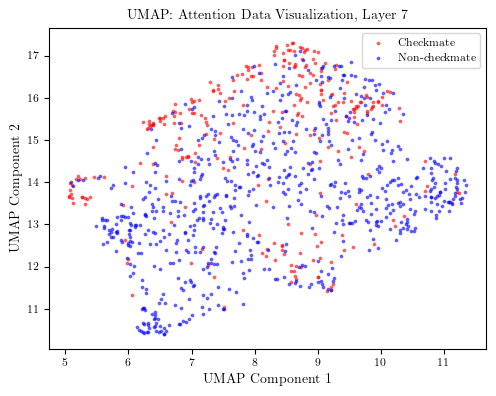

UMAP result shape: (1000, 2)


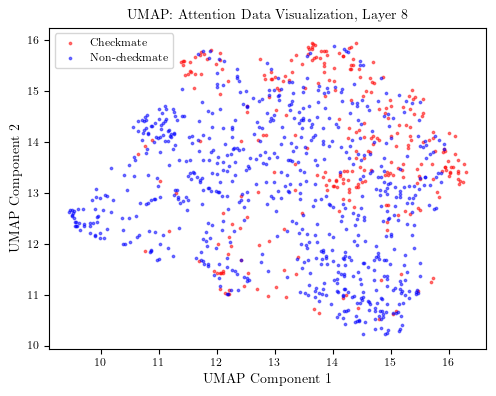

UMAP result shape: (1000, 2)


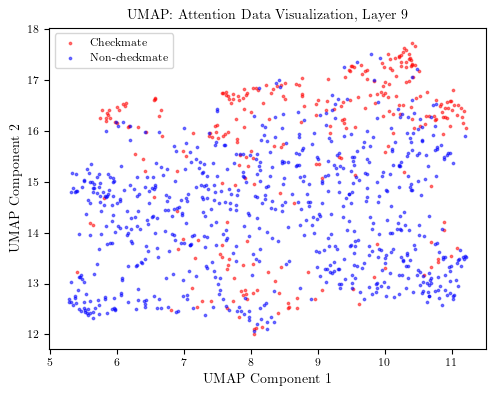

UMAP result shape: (1000, 2)


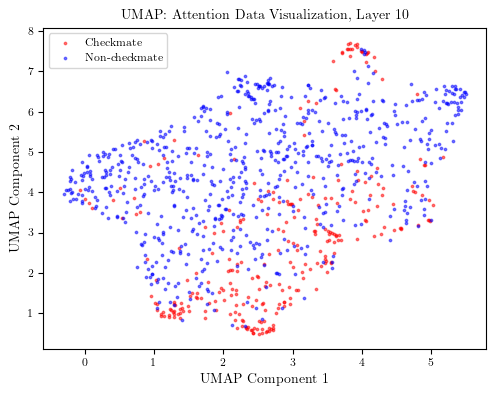

UMAP result shape: (1000, 2)


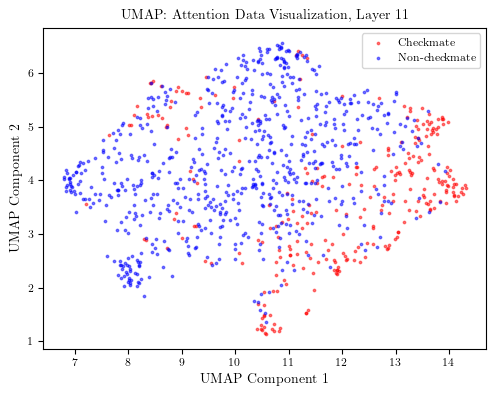

UMAP result shape: (1000, 2)


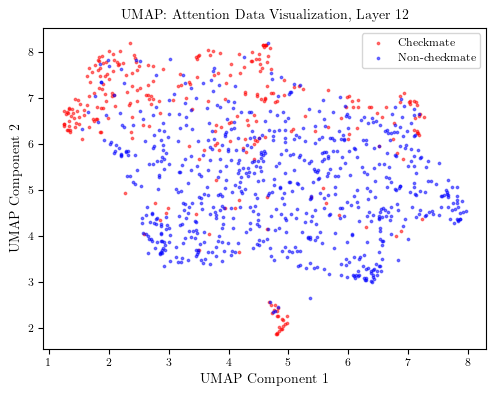

UMAP result shape: (1000, 2)


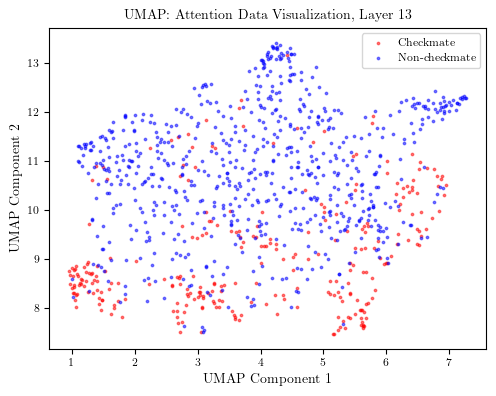

UMAP result shape: (1000, 2)


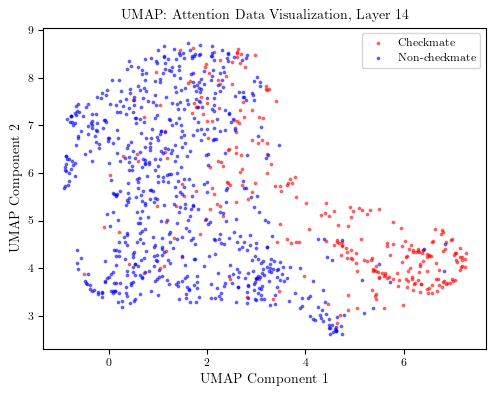

In [58]:
from umap import UMAP

for i in range(15):

    # Reshape the tensor to 2D
    attentions_2d = act_values[i].reshape(len(boards), -1)

    # Convert to numpy array
    attentions_np = attentions_2d.cpu().numpy()

    # Apply UMAP
    umap = UMAP(n_components=2)
    umap_result = umap.fit_transform(attentions_np)

    # Print the shape of the UMAP result
    print("UMAP result shape:", umap_result.shape)

    # Create a mask for checkmate puzzles
    checkmate_mask = study.puzzles.iloc[:len(boards)]["Themes"].apply(lambda x: "mateIn2" in x).values

    # Plot UMAP results
    fig, ax = plt.subplots(figsize=(5, 4))
    scatter_checkmate = ax.scatter(umap_result[checkmate_mask, 0], umap_result[checkmate_mask, 1], 
                                alpha=0.5, c='red', label='Checkmate', s=3)
    scatter_non_checkmate = ax.scatter(umap_result[~checkmate_mask, 0], umap_result[~checkmate_mask, 1], 
                                    alpha=0.5, c='blue', label='Non-checkmate', s=3)

    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.set_title(f'UMAP: Attention Data Visualization, Layer {i}')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [69]:
study = CheckmateStudy(load_all=False)


In [ ]:
possibilities = study.get_possibility_list('n', lengths=[3])
study.plot_attention_grid('n', possibilities, n_cols=2, vmax=0.73, filename="attention_grid_3_checkmate")
possibilities = study.get_possibility_list('n', lengths=[5])
study.plot_attention_grid('n', possibilities, n_cols=2, vmax=0.73, filename="attention_grid_5_checkmate")

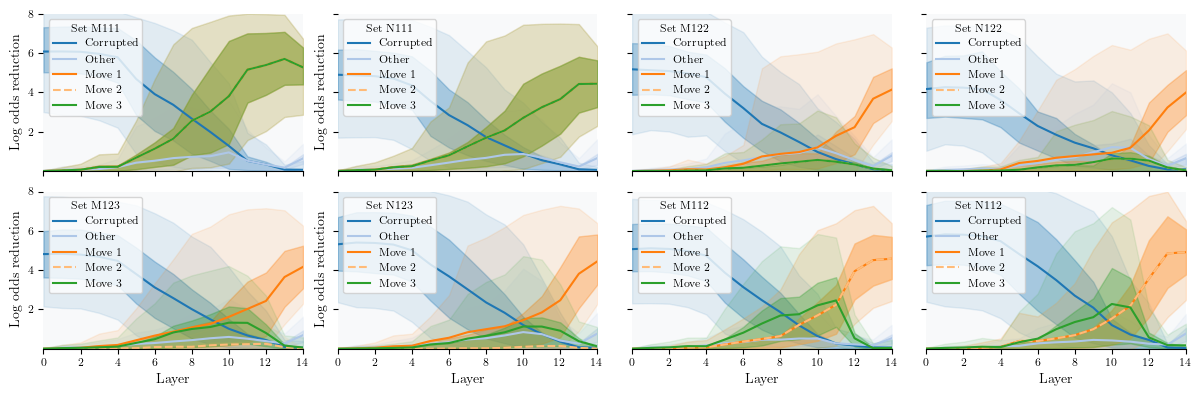

<Figure size 640x480 with 0 Axes>

In [73]:
possibilities = study.get_possibility_list('n', lengths=[3])
study.plot_residual_effects_grid('n', possibilities, n_cols=2, filename="residual_effects_3_checkmate")

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/checkmate_study.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", title=f"Set {'M' if mate else 'N'}{row_col[2]}")
/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/checkmate_study.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", title=f"Set {'M' if mate else 'N'}{row_col[2]}")
/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/checkmate_study.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", title=f"Set {'M' if mate else 'N'}{row_col[2]}")


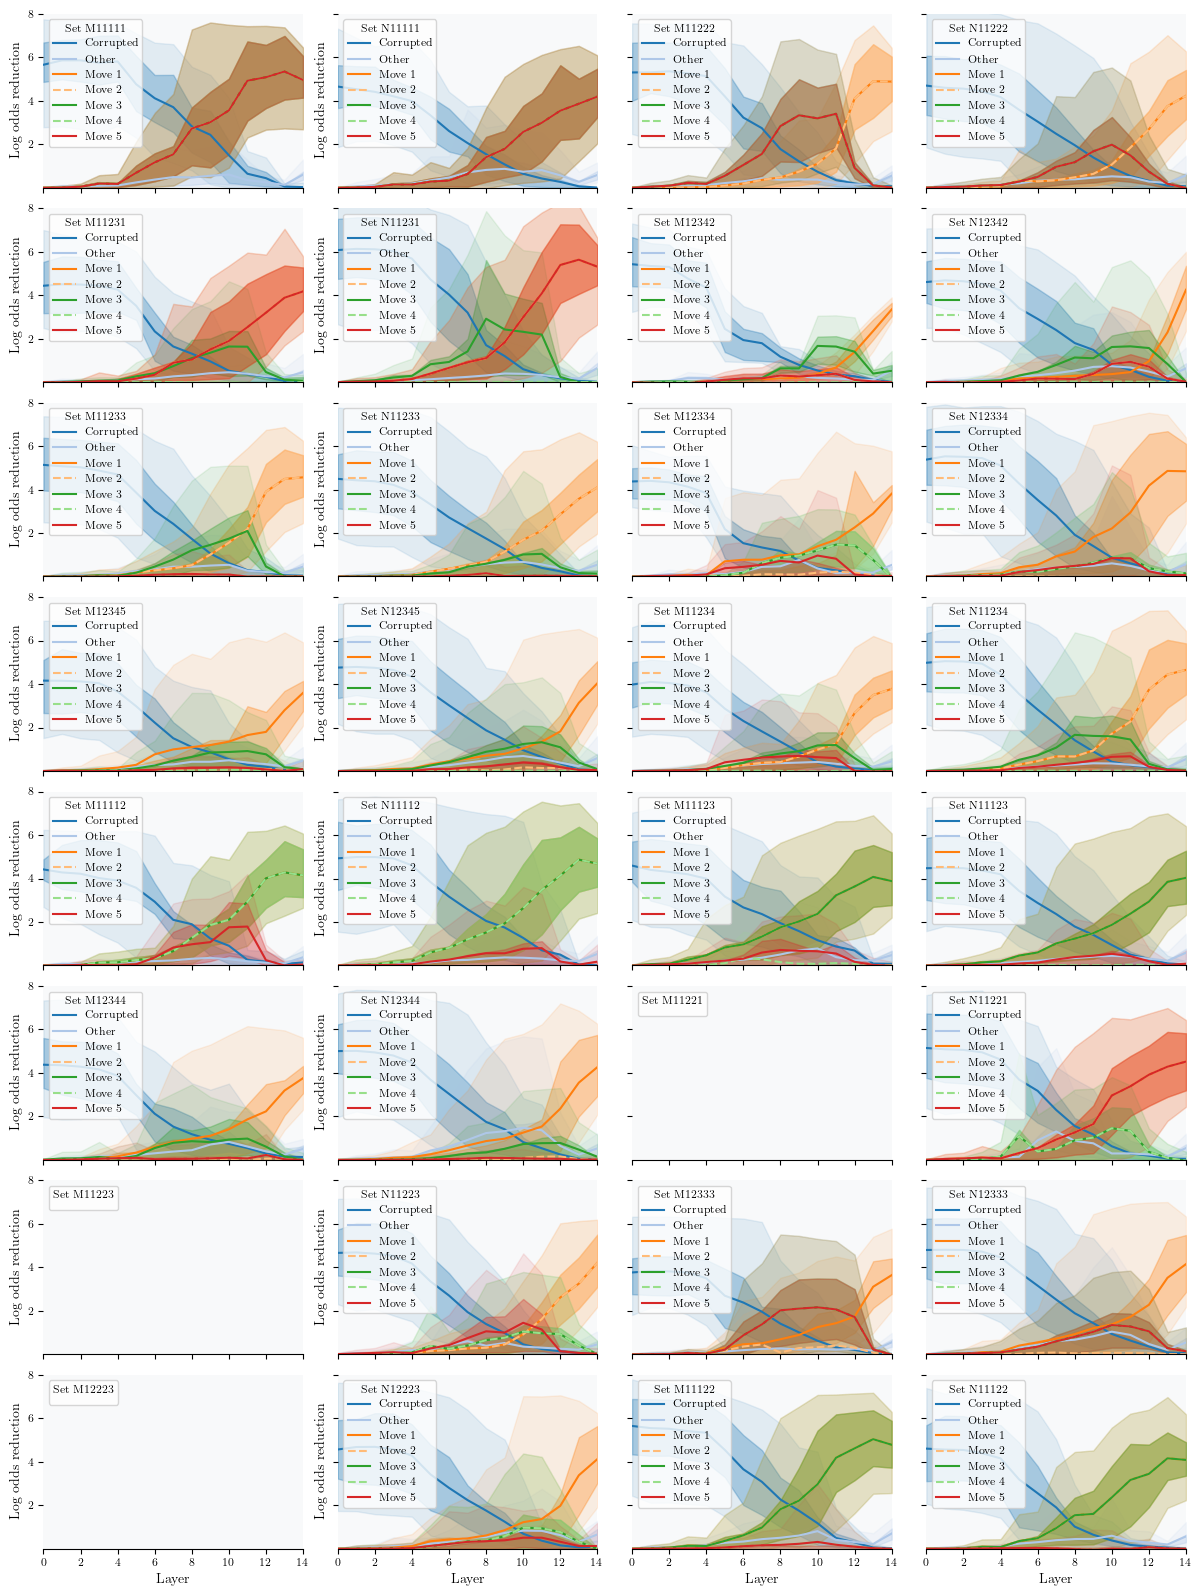

<Figure size 640x480 with 0 Axes>

In [74]:
possibilities = study.get_possibility_list('n', lengths=[5])
study.plot_residual_effects_grid('n', possibilities, n_cols=2, filename="residual_effects_5_checkmate")

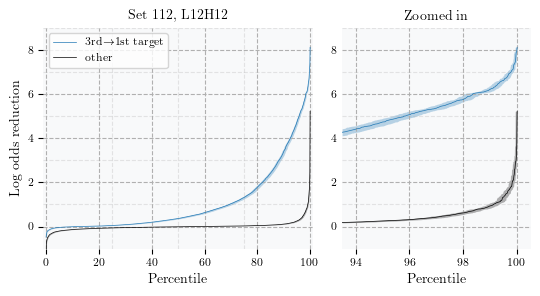

In [79]:
case, puzzle_set = ('L12H12', "112")
tag = ''
filename = None
ablation_study = AblationStudy(folder_name=case + ("_" + tag if tag != '' else "") + "_" + puzzle_set)
ablation_study.plot_ablation_effects(filename=None if filename is None else filename + "_" + case + ("_" + tag if tag != '' else "")+ "_" + puzzle_set, puzzle_set=puzzle_set, LH=case)

In [83]:
ablation_study.ablation['other']

torch.Size([7394])

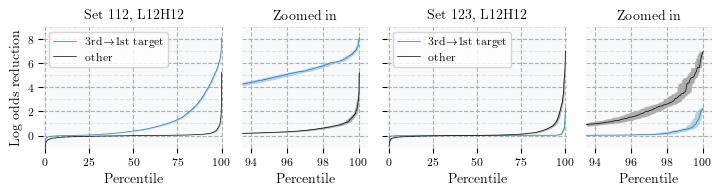

In [75]:
ablation_study = AblationStudy(folder_name="")
ablation_configs = [
    ('L12H12', "112"),
    ('L12H12', "123")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_3")

In [77]:
ablation_study.ablations

AttributeError: 'AblationStudy' object has no attribute 'ablations'

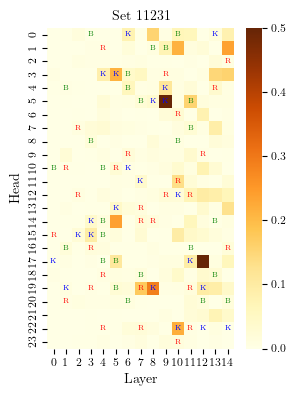

In [47]:
study = DoubleAttentionStudy(load_all=False)
possibility = '11231'
study.plot_attention('n', possibility)

In [20]:
double_effects = -study.double_attention_sets['n'][possibility]['2'].cpu().numpy()
effects = -study.attention_sets['n'][possibility][:16].cpu().numpy()
mean_double_effects = double_effects.mean(axis=0)
mean_effects = effects.mean(axis=0)

In [21]:
# Get indices of highest entries in decreasing order
top_indices = np.argsort(mean_double_effects.flatten())[::-1]

# Print the top 10 indices and their corresponding values
print("Top 10 indices and values:")
for i, idx in enumerate(top_indices[:20]):
    indices = np.unravel_index(idx, mean_double_effects.shape)
    #print(indices)
    layer_inds = [layer for j, layer in enumerate(indices) if j%2 == 0]
    head_inds = [head for j, head in enumerate(indices) if j%2 == 1]
    layers = [layer_inds[0]] + [layer + layer_inds[0] for layer in layer_inds[1:]]
    heads = head_inds
    #print(layers, heads)
    single_effects = np.sum([effects[:, layers[i], heads[i]] for i in range(len(layers))], axis=0)
    extra = np.mean(double_effects[:, *indices] - single_effects, axis=0)
    print(f"{i+1}. Index: ({layers}, {heads}), Value: {mean_double_effects[*indices]:.4f}, Extra: {extra:.4f} ({[effects[:, layers[i], heads[i]].mean() for i in range(len(layers))]})")

Top 10 indices and values:
1. Index: ([12, 13], [12, 3]), Value: 1.2021, Extra: 0.0283 ([0.8619289, 0.31192338])
2. Index: ([12, 13], [12, 1]), Value: 1.0414, Extra: 0.0000 ([0.8619289, 0.17941803])
3. Index: ([11, 12], [12, 12]), Value: 1.0164, Extra: 0.0098 ([0.14460148, 0.8619289])
4. Index: ([12, 13], [12, 12]), Value: 1.0121, Extra: 0.0307 ([0.8619289, 0.11950272])
5. Index: ([11, 12], [0, 12]), Value: 0.9900, Extra: -0.0008 ([0.12896466, 0.8619289])
6. Index: ([12, 13], [12, 19]), Value: 0.9510, Extra: -0.0228 ([0.8619289, 0.111867666])
7. Index: ([12, 13], [12, 13]), Value: 0.9409, Extra: 0.0427 ([0.8619289, 0.03623239])
8. Index: ([12, 13], [12, 18]), Value: 0.9402, Extra: -0.0056 ([0.8619289, 0.08394693])
9. Index: ([12, 12], [12, 17]), Value: 0.9377, Extra: 0.0196 ([0.8619289, 0.05616547])
10. Index: ([11, 12], [19, 12]), Value: 0.9274, Extra: 0.0294 ([0.036152415, 0.8619289])
11. Index: ([12, 13], [12, 22]), Value: 0.9244, Extra: 0.0289 ([0.8619289, 0.033595666])
12. Index: 

In [22]:
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

11
Board with highest double attention in L14H20:

Top 5 attention attributions:
{'d4g7': -0.0018955729901790619, 'c7b8': -0.0014082276029512286, 'd4g1': 0.0008989589405246079, 'd4f6': -0.0007215689984150231, 'd4e3': -0.0006922241882421076}


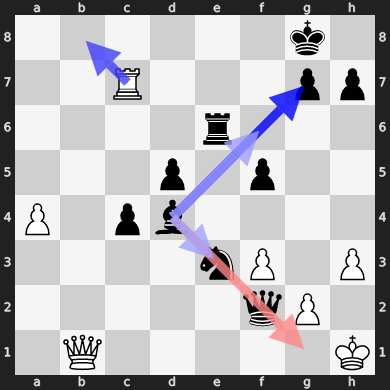

In [9]:
# Get entry with highest double attention in L14H20, from double attention set
# Get entry with highest double attention in L14H20, from double attention set
max_entry = np.argmax(double_effects[:, 5, 17, 0, 19])
print(max_entry)
good_puzzle = study.puzzle_sets['n'][possibility].iloc[max_entry]
good_board = LeelaBoard.from_puzzle(good_puzzle)

print("Board with highest double attention in L14H20:")
good_board.plot()

# Visualize attention patterns
attribution = attention_attribution(
    [good_board], layer=5, head=17, model=model, return_pt=True
)[0]
values, colors = top_k_attributions(attribution, good_board, k=5)
print("\nTop 5 attention attributions:")
print(values)
good_board.plot(arrows=colors, show_lastmove=False)    



Top 5 attention attributions:
{'g8f7': 0.0015825539594516158, 'f7g6': -0.0012480540899559855, 'f7g8': -0.0008403860265389085, 'e3f2': 0.0008272872655652463, 'b8c7': -0.0007743341848254204}


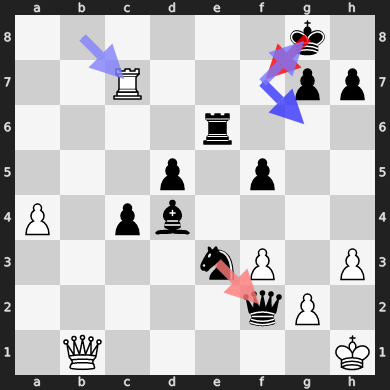

In [10]:
attribution = attention_attribution(
    [good_board], layer=5, head=19, model=model, return_pt=True
)[0]
values, colors = top_k_attributions(attribution, good_board, k=5)
print("\nTop 5 attention attributions:")
print(values)
good_board.plot(arrows=colors, show_lastmove=False)

In [11]:
good_puzzle.principal_variation

['b1b8', 'e6e8', 'b8e8']

In [56]:
mask_1 = study.puzzle_sets['n'][possibility]["Themes"].apply(lambda x: "mateIn3" in x)
mask_2 = ~mask_1
mask_1, mask_2 = mask_1.to_numpy(), mask_2.to_numpy()

In [57]:
sum(mask_1), sum(mask_2)

(25, 1335)

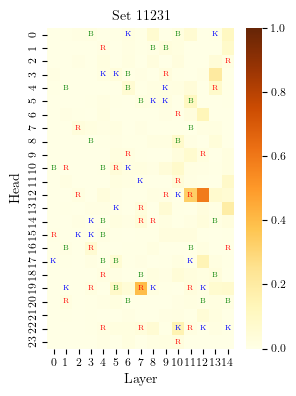

In [58]:
study.plot_attention('n', possibility, mask=mask_1, vmax=1.)

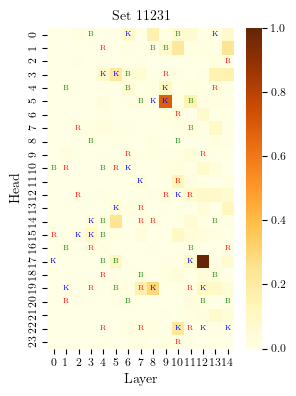

In [59]:
study.plot_attention('n', possibility, mask=mask_2, vmax=1.)

In [ ]:
attribution = attention_attribution(
    [good_board], layer=12, head=12, model=model, return_pt=True
)[0]
values, colors = top_k_attributions(attribution, good_board, k=5)
print(values)
good_board.plot(arrows=colors, show_lastmove=False)

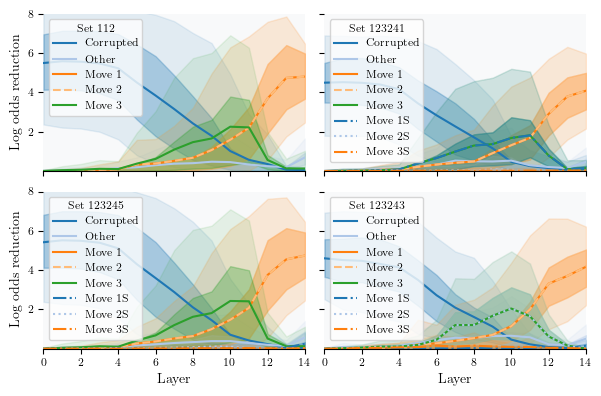

<Figure size 640x480 with 0 Axes>

In [5]:
possibilities = [('s', possibility) for possibility in study.get_possibility_list('s', lengths=[3]) if possibility[1] == possibility[3] != possibility[5]]
possibilities = [('n', '112')] + possibilities
study.plot_residual_effects_grid(possibilities, y_max=8, n_cols=2, filename="paper_residual_effects_3S_112")

## Attention heads

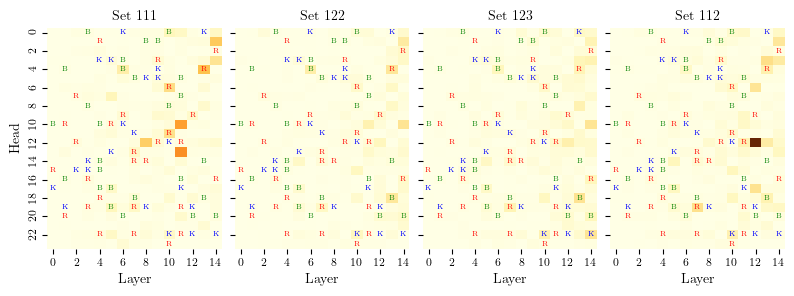

<Figure size 640x480 with 0 Axes>

In [7]:
possibilities = study.get_possibility_list('n', lengths=[3])
study.plot_attention_grid('n', possibilities, n_cols=4, vmax=0.73, filename="paper_attention_heads_3")

# L12H12

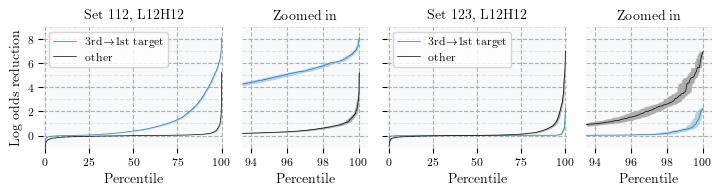

In [4]:
ablation_study = AblationStudy(folder_name="")
ablation_configs = [
    ('L12H12', "112"),
    ('L12H12', "123")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_3")

In [4]:
from leela_interp.core.ablation_study import AblationCheckmateStudy

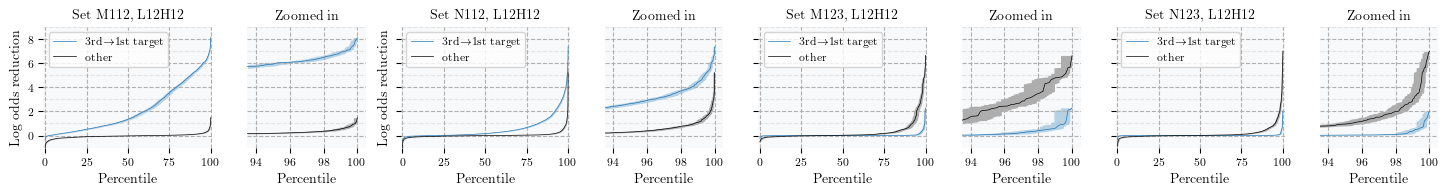

In [6]:
ablation_study = AblationCheckmateStudy(folder_name="")
ablation_configs = [
    ('L12H12', "112"),
    ('L12H12', "123")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_3_checkmate")

[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


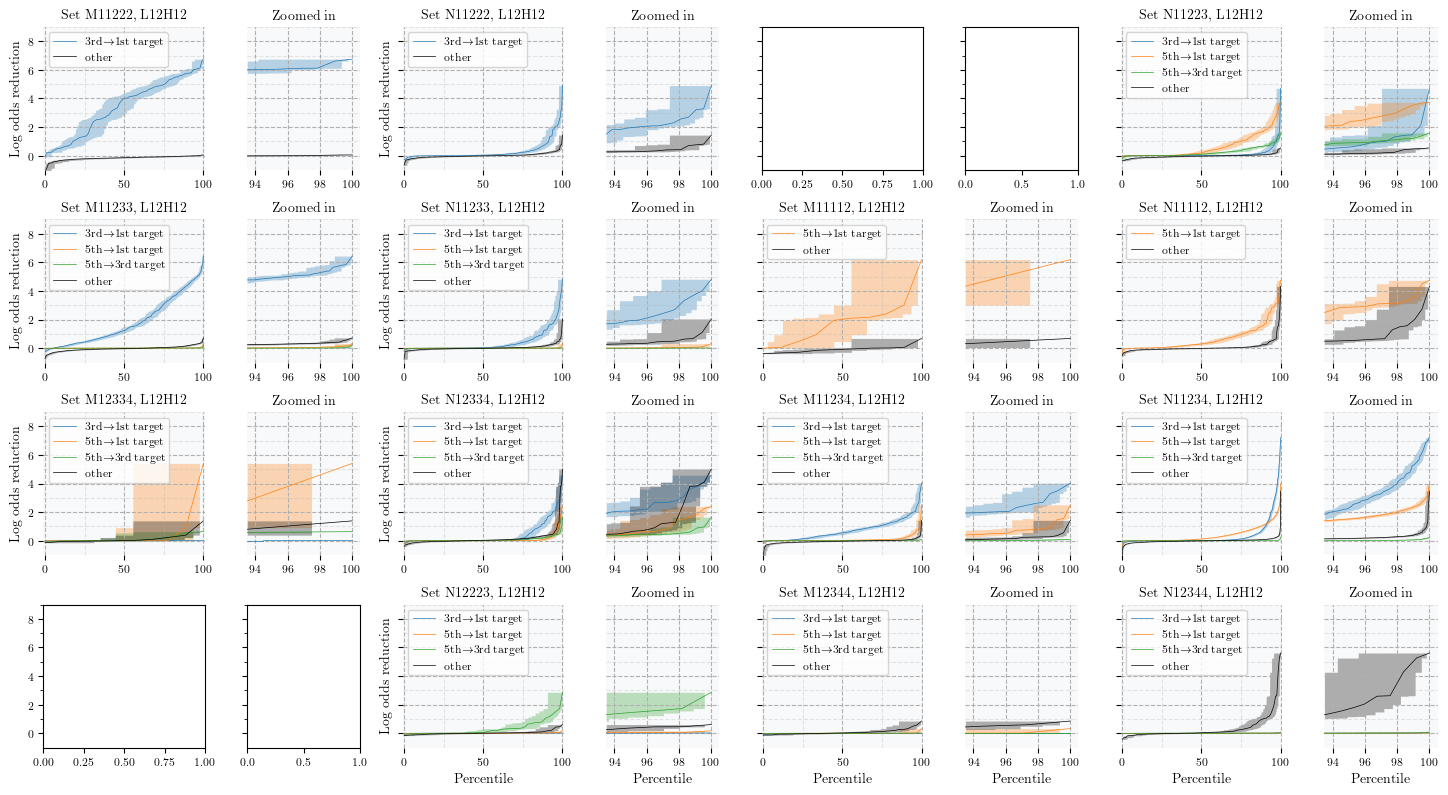

[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


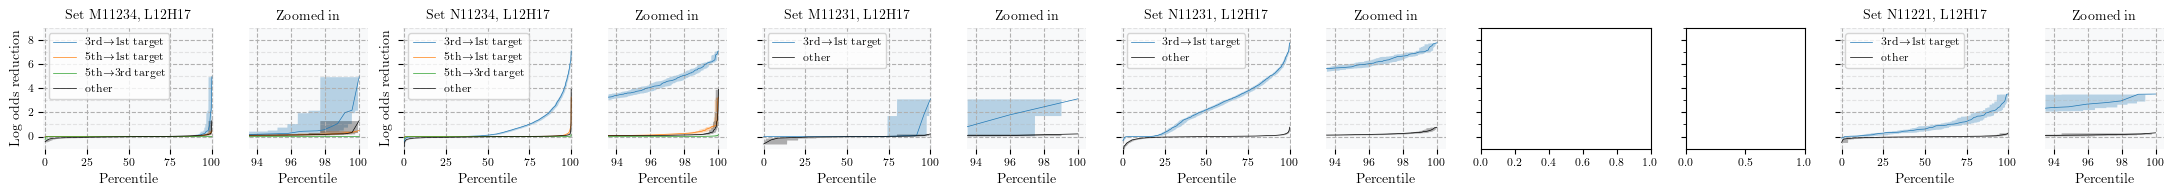

[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


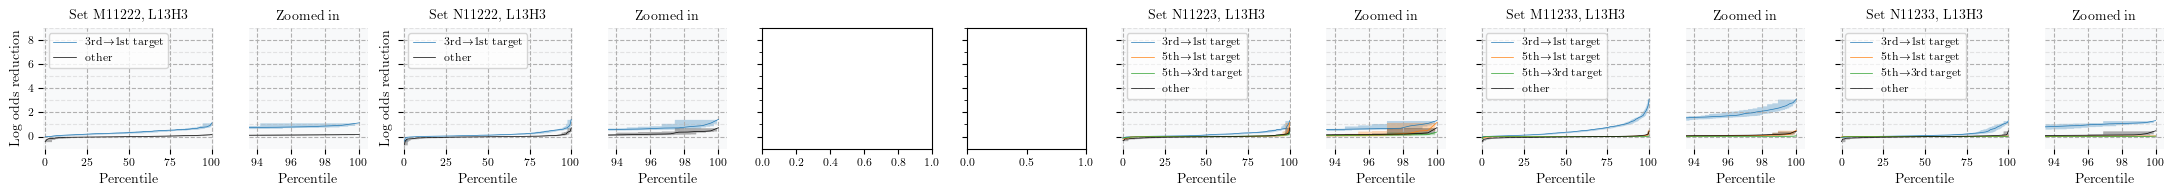

[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


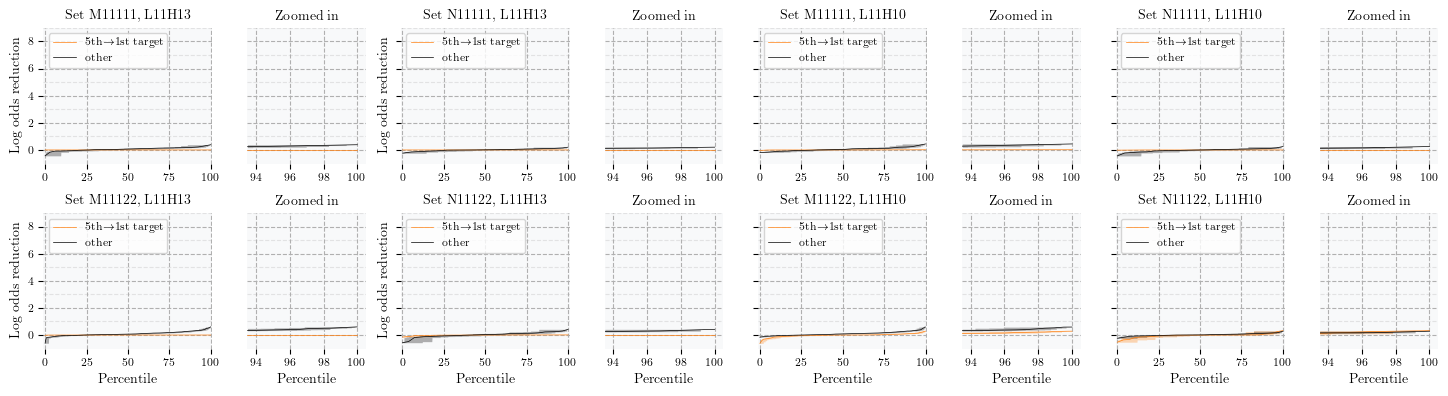

In [12]:
ablation_study = AblationCheckmateStudy(folder_name="")
ablation_configs = [
    ('L12H12', "11222"),
    ('L12H12', "11223"),
    ('L12H12', "11233"),
    ('L12H12', "11112"),
    ('L12H12', "12334"),
    ('L12H12', "11234"),
    ('L12H12', "12223"),
    ('L12H12', "12344")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_5_L12H12_checkmate", tag='n')
ablation_configs = [
    ('L12H17', "11234"),
    ('L12H17', "11231"),
    ('L12H17', "11221")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_5_L12H17_checkmate", tag='n')
ablation_configs = [
    ('L13H3', "11222"),
    ('L13H3', "11223"),
    ('L13H3', "11233")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_5_L13H3_checkmate", tag='n')
ablation_configs = [
    ('L11H13', "11111"),
    ('L11H10', "11111"),
    ('L11H13', "11122"),
    ('L11H10', "11122")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_5_remaining_checkmate", tag='n')
# ablation_configs = [
#     ('L12H12', "11222"),
#     ('L13H3', "11222"),
#     ('L12H12', "11223"),
#     ('L13H3', "11223"),
#     ('L12H12', "11233"),
#     ('L13H3', "11233"),
#     ('L12H12', "11112"),
#     ('L12H12', "12334"),
#     ('L12H12', "11234"),
#     ('L12H17', "11234"),
#     ('L12H17', "11231"),
#     ('L12H17', "11221"),
#     ('L11H13', "11111"),
#     ('L11H10', "11111"),
#     ('L11H13', "11122"),
#     ('L11H10', "11122"),
#     ('L12H12', "12223"),
#     ('L12H12', "12344")
# ]
# ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_5", tag='n')

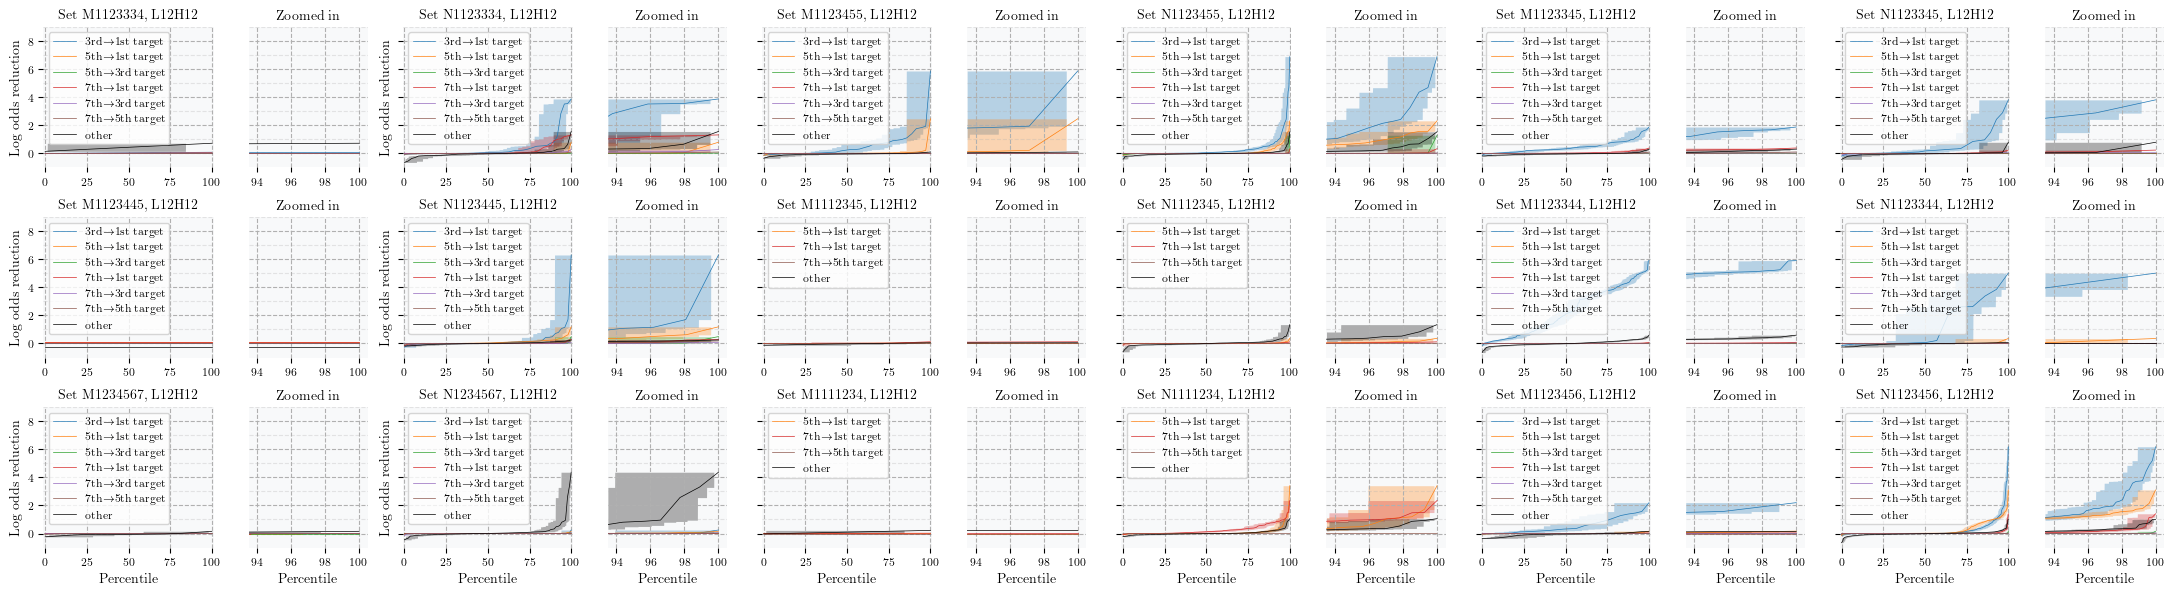

In [14]:
ablation_study = AblationCheckmateStudy(folder_name="", puzzlename="pv7")
ablation_configs = [
    ('L12H12', "1123334"),
    ('L12H12', "1123455"),
    ('L12H12', "1123345"),
    ('L12H12', "1123445"),
    ('L12H12', "1112345"),
    ('L12H12', "1123344"),
    ('L12H12', "1234567"),
    ('L12H12', "1111234"),
    ('L12H12', "1123456")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_7_L12H12_checkmate", tag='pv7_n')

# Fifth move analysis

## Residual stream

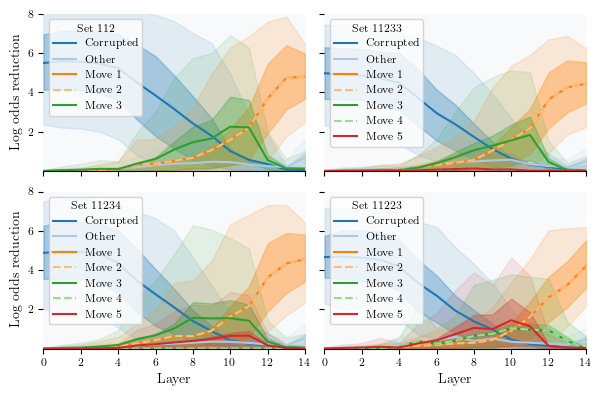

<Figure size 640x480 with 0 Axes>

In [24]:
study = FifthMoveStudy(load_all=False)
possibilities = [possibility for possibility in study.get_possibility_list('n', lengths=[5]) if len(set([possibility[0], possibility[2], possibility[4]])) == 3 and possibility[:3] == '112']
possibilities = ['112'] + possibilities
study.plot_residual_effects_grid('n', possibilities, y_max=8, n_cols=2, filename="paper_residual_effects_5_112")

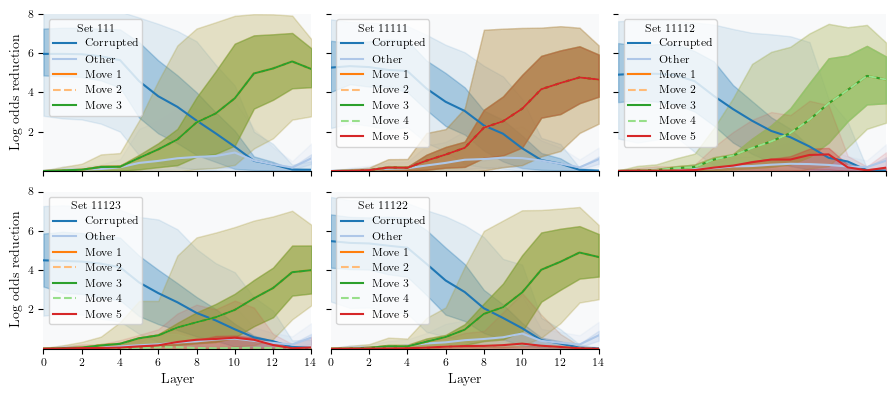

<Figure size 640x480 with 0 Axes>

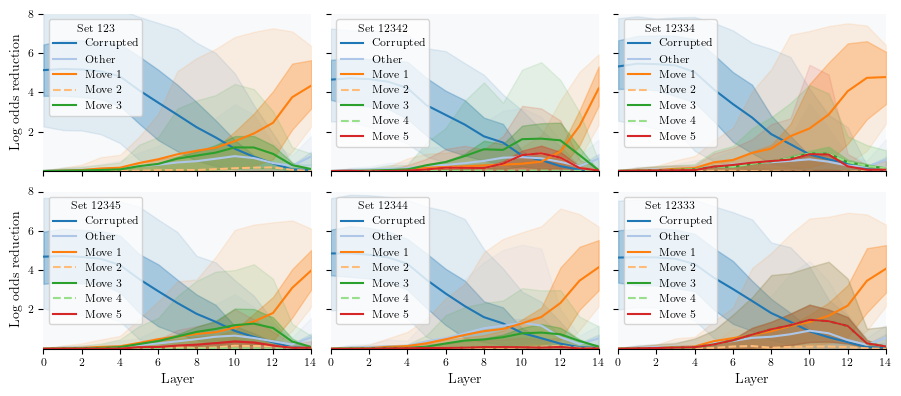

<Figure size 640x480 with 0 Axes>

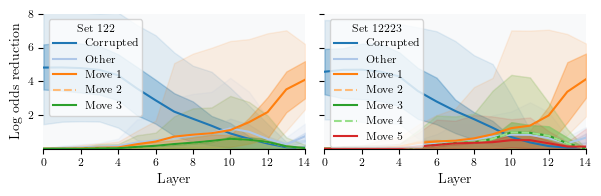

<Figure size 640x480 with 0 Axes>

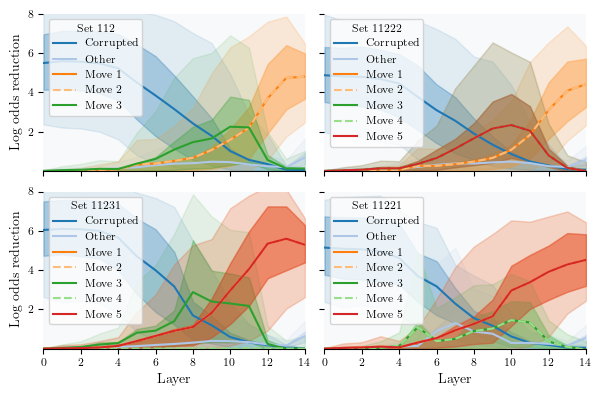

<Figure size 640x480 with 0 Axes>

In [6]:
possibilities = [possibility for possibility in study.get_possibility_list('n', lengths=[5]) if possibility[:3] == '111']
possibilities = ['111'] + possibilities
study.plot_residual_effects_grid('n', possibilities, y_max=8, n_cols=3, filename="paper_residual_effects_5_111")
possibilities = [possibility for possibility in study.get_possibility_list('n', lengths=[5]) if possibility[:3] == '123']
possibilities = ['123'] + possibilities
study.plot_residual_effects_grid('n', possibilities, y_max=8, n_cols=3, filename="paper_residual_effects_5_123")
possibilities = [possibility for possibility in study.get_possibility_list('n', lengths=[5]) if possibility[:3] == '122']
possibilities = ['122'] + possibilities
study.plot_residual_effects_grid('n', possibilities, y_max=8, n_cols=2, filename="paper_residual_effects_5_122")
possibilities = [possibility for possibility in study.get_possibility_list('n', lengths=[5]) if len(set([possibility[0], possibility[2], possibility[4]])) != 3 and possibility[:3] == '112']
possibilities = ['112'] + possibilities
study.plot_residual_effects_grid('n', possibilities, y_max=8, n_cols=2, filename="paper_residual_effects_5_112R")

## Attention heads

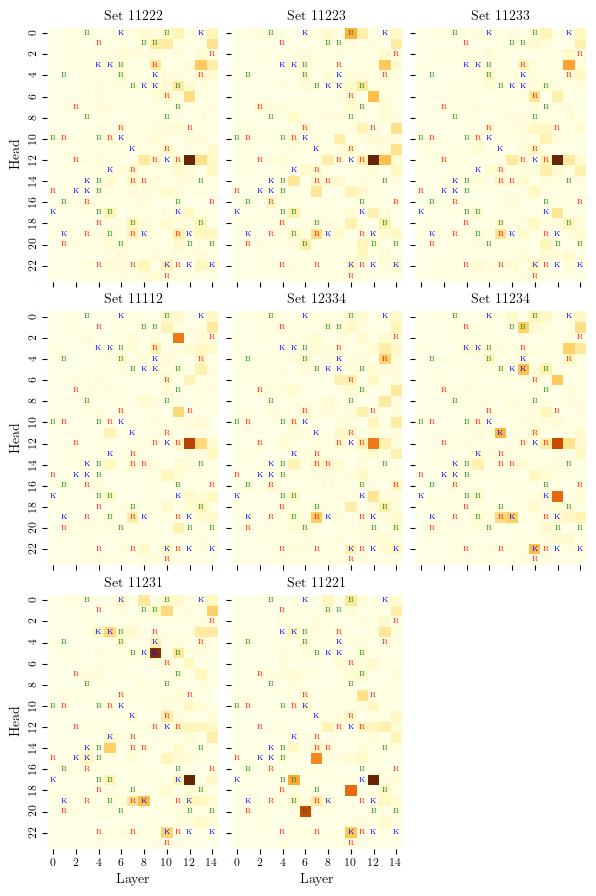

<Figure size 640x480 with 0 Axes>

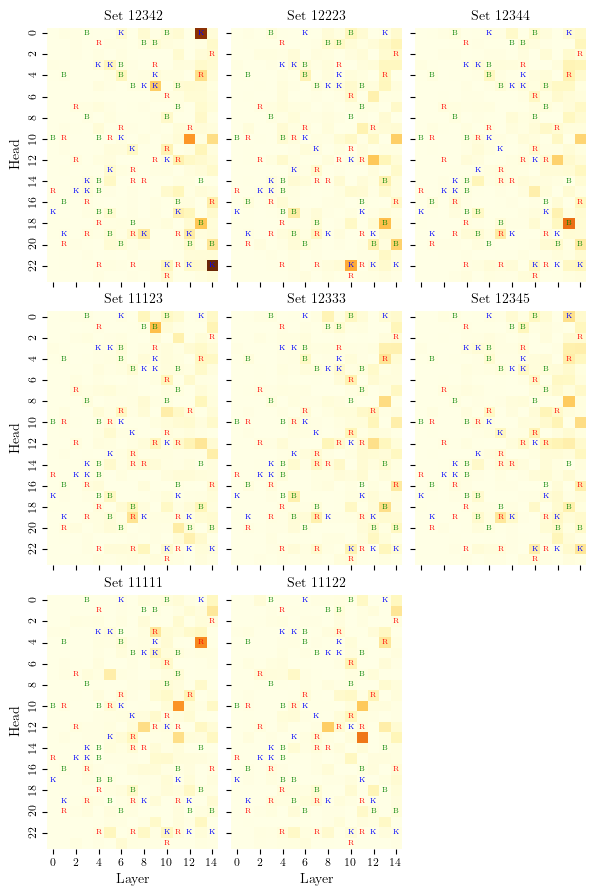

<Figure size 640x480 with 0 Axes>

In [8]:
#possibilities = study.get_possibility_list('n', lengths=[5])
# Ordering by hand
possibilities = ['11222', '11223', '11233'] #L12H12, L13H3
possibilities += ['11112', '12334'] #L12H12
possibilities += ['11234'] #L12H12, L12H17
possibilities += ['11231', '11221'] #L12H17
study.plot_attention_grid('n', possibilities, n_cols=3, vmax=0.73, filename="paper_attention_heads_5A")
possibilities = ['12342', '12223', '12344'] #random
possibilities += ['11123', '12333', '12345'] #low
possibilities += ['11111', '11122'] #L11H13, L11H10
study.plot_attention_grid('n', possibilities, n_cols=3, vmax=0.73, filename="paper_attention_heads_5B")

# L12H12, L12H17, L11H10, L11H13, L13H3

In [11]:
# ablation_configs = [
#     ('L12H12', "11222"),
#     ('L13H3', "11222"),
#     ('L12H12', "11223"),
#     ('L13H3', "11223"),
#     ('L12H12', "11233"),
#     ('L13H3', "11233"),
#     ('L12H12', "11112"),
#     ('L12H12', "12334"),
#     ('L12H12', "11234"),
#     ('L12H17', "11234"),
#     ('L12H17', "11231"),
#     ('L12H17', "11221"),
#     ('L11H13', "11111"),
#     ('L11H10', "11111"),
#     ('L11H13', "11122"),
#     ('L11H10', "11122"),
#     ('L12H12', "12223"),
#     ('L12H12', "12344")
# ]

ablation_configs = [
    ('L13H3', "11222"),
]

for config in ablation_configs:
    layer_head, puzzle = config
    layer = layer_head[1:3]  # Extract layer number
    head = layer_head[4:]    # Extract head number
    
    command = f"python3 scripts/run_single_head.py --filename interesting_puzzles_n_{puzzle} --layer {layer} --head {head} --device cuda --main"
    
    print(f"Running command: {command}")
    subprocess.run(command, shell=True)
    print("Command completed.\n")

Running command: python3 scripts/run_single_head.py --filename interesting_puzzles_n_11222 --layer 13 --head 3 --device cuda --main
Using device: cuda


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Command completed.



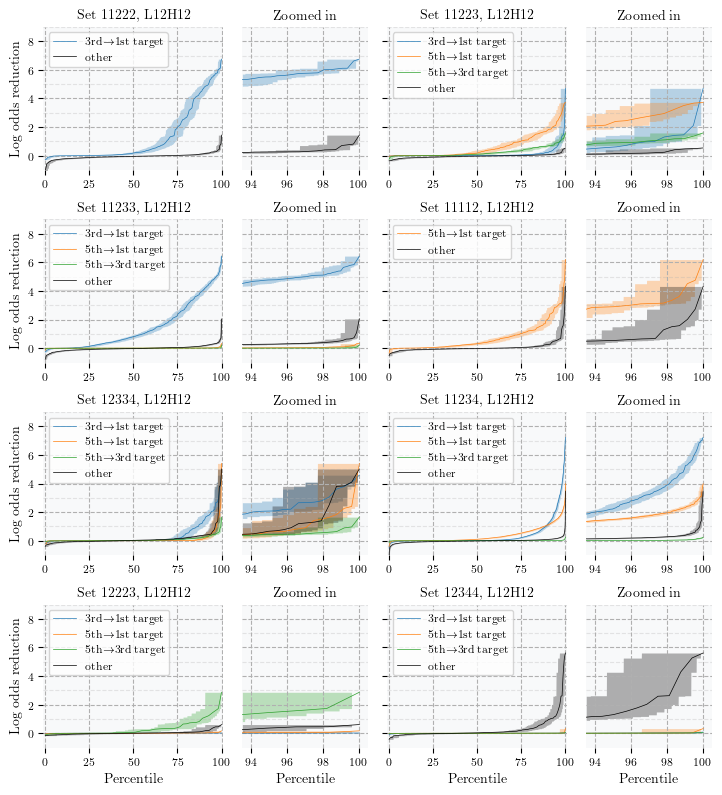

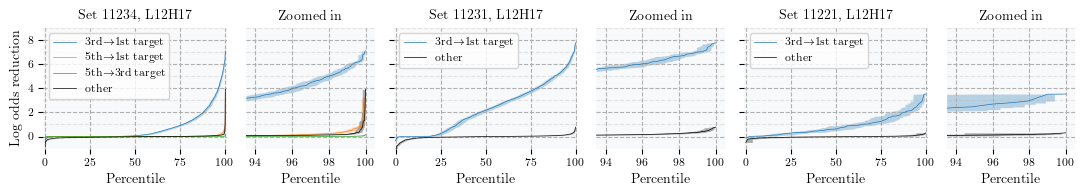

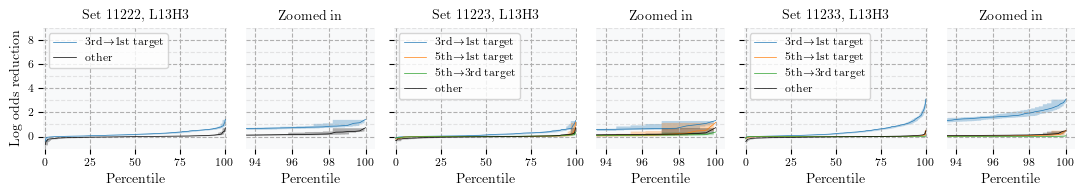

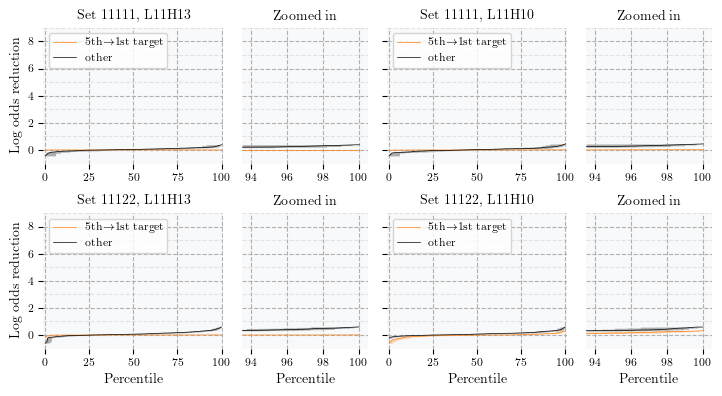

In [9]:
ablation_study = AblationStudy(folder_name="")
ablation_configs = [
    ('L12H12', "11222"),
    ('L12H12', "11223"),
    ('L12H12', "11233"),
    ('L12H12', "11112"),
    ('L12H12', "12334"),
    ('L12H12', "11234"),
    ('L12H12', "12223"),
    ('L12H12', "12344")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_5_L12H12", tag='n')
ablation_configs = [
    ('L12H17', "11234"),
    ('L12H17', "11231"),
    ('L12H17', "11221")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_5_L12H17", tag='n')
ablation_configs = [
    ('L13H3', "11222"),
    ('L13H3', "11223"),
    ('L13H3', "11233")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_5_L13H3", tag='n')
ablation_configs = [
    ('L11H13', "11111"),
    ('L11H10', "11111"),
    ('L11H13', "11122"),
    ('L11H10', "11122")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=2, filename="paper_ablation_effects_5_remaining", tag='n')
# ablation_configs = [
#     ('L12H12', "11222"),
#     ('L13H3', "11222"),
#     ('L12H12', "11223"),
#     ('L13H3', "11223"),
#     ('L12H12', "11233"),
#     ('L13H3', "11233"),
#     ('L12H12', "11112"),
#     ('L12H12', "12334"),
#     ('L12H12', "11234"),
#     ('L12H17', "11234"),
#     ('L12H17', "11231"),
#     ('L12H17', "11221"),
#     ('L11H13', "11111"),
#     ('L11H10', "11111"),
#     ('L11H13', "11122"),
#     ('L11H10', "11122"),
#     ('L12H12', "12223"),
#     ('L12H12', "12344")
# ]
# ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_5", tag='n')

## Probing

In [31]:
possibility = '12345'

command = f"python3 scripts/probing.py --filename interesting_puzzles_n_{possibility} --main --random_model --n_seeds 5 --max_goal_square 5 --min_goal_square 1 --add_opponent"

print(f"Running command: {command}")
subprocess.run(command, shell=True)
print("Command completed.\n")

Running command: python3 scripts/probing.py --filename interesting_puzzles_n_12345 --main --random_model --n_seeds 5 --max_goal_square 5 --min_goal_square 1 --add_opponent
common_str: n
Using 430 puzzles total, 301 for training.
Using device: cuda


100%|██████████| 15/15 [00:00<00:00, 25.18it/s]


Using device: cuda


100%|██████████| 15/15 [00:00<00:00, 25.14it/s]


Command completed.



185


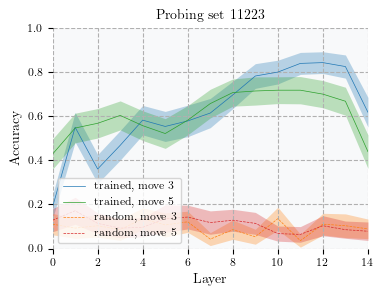

In [34]:
cases = ['11223']
for case in cases:
    probing_study = ProbingStudy(case_number=case, tag_name='n')#, add_opponent=True, start_goal_square=1)
    print(probing_study.n_examples)
    probing_study.plot_probe_results(filename="paper_probe_results_" + case)

# 7th move analysis

## Residual stream

In [38]:
study = FifthMoveStudy(puzzlename="pv7", load_all=False)

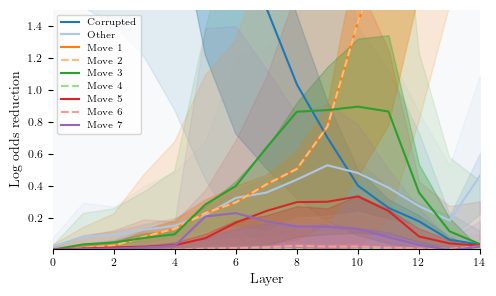

In [42]:
study.plot_residual_effects('n', '1123456', filename="paper_residual_effects_7_1123456", y_max=1.5)

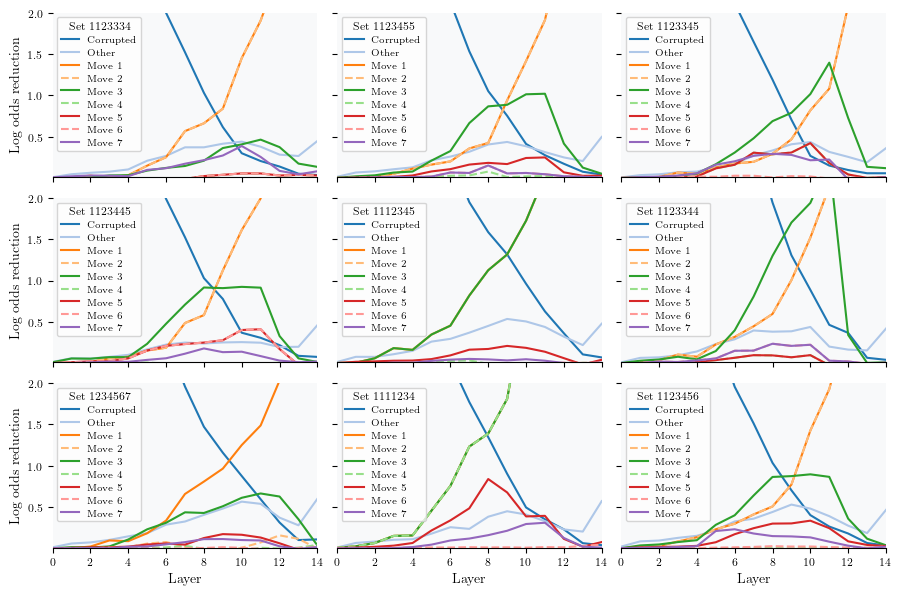

<Figure size 640x480 with 0 Axes>

In [36]:
possibilities = study.get_possibility_list('n', lengths=[7])
study.plot_residual_effects_grid('n', possibilities, n_cols=3, filename="paper_residual_effects_7", y_max=2, plot_ci=False)

## Attention heads

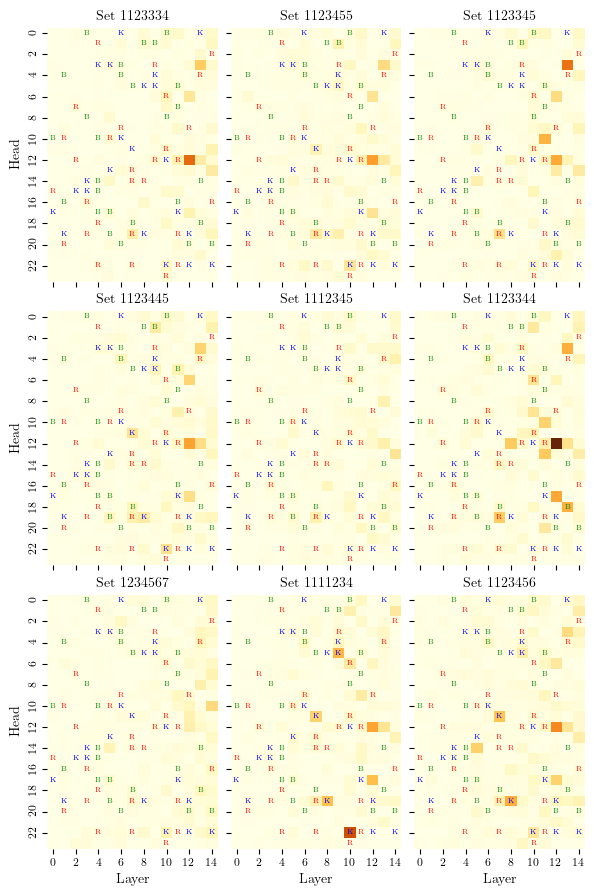

<Figure size 640x480 with 0 Axes>

In [14]:
possibilities = study.get_possibility_list('n', lengths=[7])
study.plot_attention_grid('n', possibilities, n_cols=3, filename="paper_attention_heads_7", vmax=0.73)

In [17]:
[(possibility, len(study.puzzle_sets['n'][possibility])) for possibility in possibilities]

[('1123334', 51),
 ('1123455', 224),
 ('1123345', 94),
 ('1123445', 54),
 ('1112345', 101),
 ('1123344', 223),
 ('1234567', 100),
 ('1111234', 137),
 ('1123456', 541)]

In [24]:
# import subprocess

# ablation_configs = [
#     ('L12H12', "1112345"),
#     ('L12H12', "1111234"),
# ]

# for config in ablation_configs:
#     layer_head, puzzle = config
#     layer = layer_head[1:3]  # Extract layer number
#     head = layer_head[4:]    # Extract head number
    
#     command = f"python3 scripts/run_single_head.py --filename interesting_puzzles_pv7_n_{puzzle} --layer {layer} --head {head} --device cuda --main"
    
#     print(f"Running command: {command}")
#     subprocess.run(command, shell=True)
#     print("Command completed.\n")

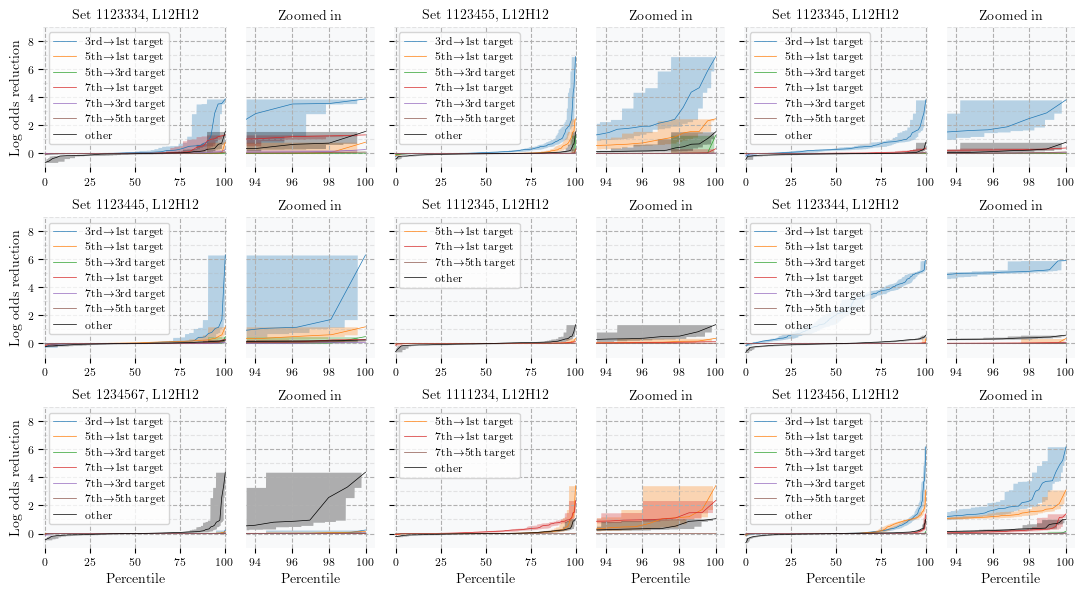

In [15]:
ablation_study = AblationStudy(folder_name="")
ablation_configs = [
    ('L12H12', "1123334"),
    ('L12H12', "1123455"),
    ('L12H12', "1123345"),
    ('L12H12', "1123445"),
    ('L12H12', "1112345"),
    ('L12H12', "1123344"),
    ('L12H12', "1234567"),
    ('L12H12', "1111234"),
    ('L12H12', "1123456")
]
ablation_study.plot_ablation_effects_grid(ablation_configs, n_cols=3, filename="paper_ablation_effects_7_L12H12", tag='pv7_n')

## Probing

In [ ]:
for possibility in possibilities:

    command = f"python3 scripts/probing.py --filename interesting_puzzles_pv7_n_{possibility} --main --random_model --n_seeds 5 --max_goal_square 7"
    
    print(f"Running command: {command}")
    subprocess.run(command, shell=True)
    print("Command completed.\n")

51


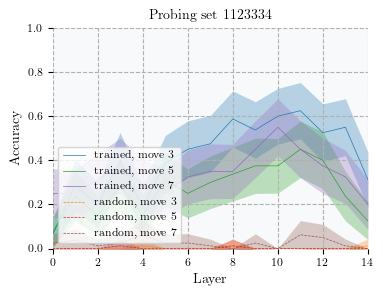

224


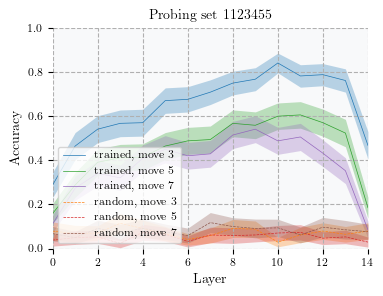

94


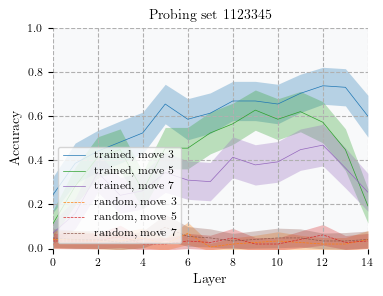

54


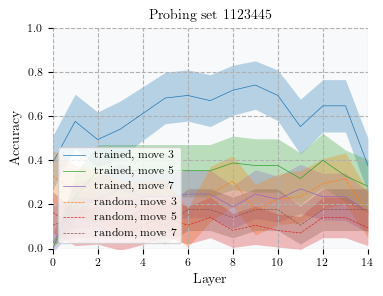

101


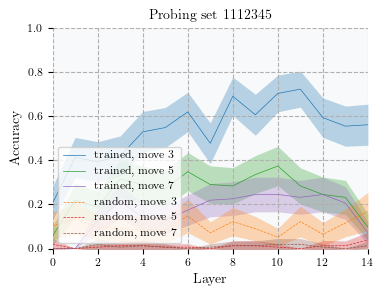

223


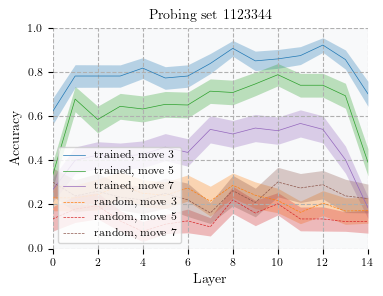

100


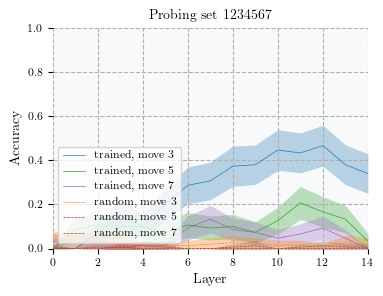

137


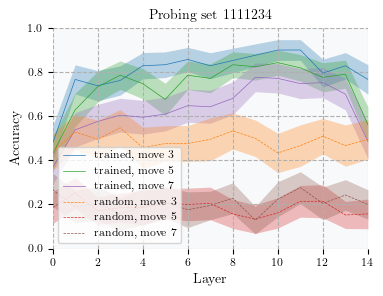

541


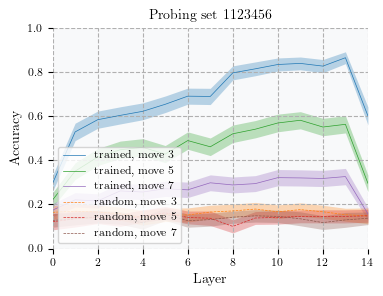

In [37]:
cases = possibilities

for case in cases:
    probing_study = ProbingStudy(case_number=case, tag_name='pv7_n')
    print(probing_study.n_examples)
    probing_study.plot_probe_results(filename="paper_probe_results_" + case)

# Double branches

In [21]:
from leela_interp.core.double_branch import DoubleBranchStudy

In [22]:
study = DoubleBranchStudy(puzzlename="nomate2", load_all=True)

123425 4 4


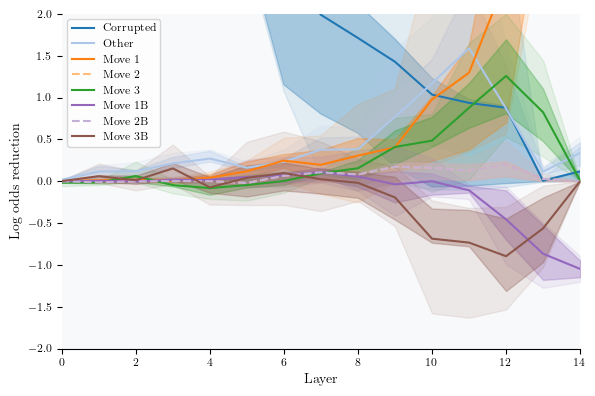

In [23]:
study.plot_residual_effects('b', '123425', filename="paper_residual_effects_123425")